# Datasets

https://mengtingwan.github.io/data/goodreads.html

- **goodreads_books.json.gz** : It contains details about each unique book.
- **
goodreads_reviews_dedup.json.** gz: It contains details about each rating given by a user on a book.

# Pip installs

Version 23.2.1: ```python.exe -m pip install --upgrade pip```
- warnings, gzip, json, re, os, requests, io, pickle, bs4, are builtin. No need to install them.


In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [ ]:
!pip install tqdm
!pip install scikit-learn

https://stackoverflow.com/questions/71470989/python-setup-py-bdist-wheel-did-not-run-successfully

In [ ]:
!pip install Cmake
!pip install pipwin
!pipwin install scikit-learn
!pip install surprise

https://github.com/pypa/pip/issues/11845

Allow write permission for python311 folder:

https://www.uwec.edu/kb/article/drives-establishing-windows-file-and-folder-level-permissions/

In [ ]:
!pip install tensorflow

In [ ]:
!pip install lxml

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gzip
import json
import re
import os
from tqdm import tqdm
import requests
from io import BytesIO
from pickle import dump, load
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances
import scipy.sparse
from scipy.sparse import hstack
from scipy import stats
from scipy.sparse import coo_matrix
from surprise import Reader, Dataset
from surprise import SVD, model_selection, accuracy
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [7]:
from multiprocessing import Process

In [8]:
import logging


In [13]:
from sklearn.metrics import plot_confusion_matrix

# Data content in user and book .gz file

### Paths

In [3]:
books_path = "content/goodreads_books.json.gz"
users_path = "content/goodreads_reviews_dedup.json.gz"
books_path_csv = "content/df_books.csv.gz"
users_path_csv = "content/df_users.csv.gz"
books_path_processed_csv = "content/df_books_processed.csv.gz"
users_path_processed_csv = "content/df_users_processed.csv.gz"
books_users_path_processed_csv = 'content/df_books_users_processed.csv.gz'

In [4]:
top50_highest_rated_books_path = "content/top50_highest_rated_books.csv"
top50_concised_books_path = "content/top50_concised_books.csv"
top50_paper_books_path = "content/top_50_paper_books.csv"
top50_e_books_path = "content/top_50_e_books.csv"
final_review_path = 'content/df_final_review.csv.gz'

### Book

In [9]:
with gzip.open(books_path, 'r') as f:
  line = f.readline()
json.loads(line)  

{'isbn': '0312853122',
 'text_reviews_count': '1',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.00',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Paperback',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'authors': [{'author_id': '604031', 'role': ''}],
 'publisher': "St. Martin's Press",
 'num_pages': '256',
 'publication_day': '1',
 'isbn13': '9780312853129',
 'publication_month': '9',
 'edition_information': '',
 'publication_year': '1984',
 'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'book_id': '5333265',
 'ratings_count': '3',
 'work_id': '5400751',
 'title': '

### Review

In [10]:
with gzip.open(users_path, 'r') as f:
  line = f.readline()
json.loads(line) 

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '24375664',
 'review_id': '5cd416f3efc3f944fce4ce2db2290d5e',
 'rating': 5,
 'review_text': "Mind blowingly cool. Best science fiction I've read in some time. I just loved all the descriptions of the society of the future - how they lived in trees, the notion of owning property or even getting married was gone. How every surface was a screen. \n The undulations of how society responds to the Trisolaran threat seem surprising to me. Maybe its more the Chinese perspective, but I wouldn't have thought the ETO would exist in book 1, and I wouldn't have thought people would get so over-confident in our primitive fleet's chances given you have to think that with superior science they would have weapons - and defenses - that would just be as rifles to arrows once were. \n But the moment when Luo Ji won as a wallfacer was just too cool. I may have actually done a fist pump. Though by the way, if the Dark Forest theory is right - and I

# Data Preparation

### Parsers
We have the structure of the data, but we need to organize this data into the proper format for building the recommendation system.

In [11]:
class Parser:
    USER_FIELDS = ['book_id', 'user_id', 'review_text', 'n_votes', 'rating']
    BOOK_FIELDS = ['book_id', 'title_without_series', 'description', 'publication_year', 
                   'publisher', 'ratings_count', 'average_rating', 'image_url', 'url', 
                   'is_ebook', 'num_pages']

    @staticmethod
    def parse(line, fields):
        return {field: line[field] for field in fields}

In [12]:
# It will parse all information in ‘goodreads_reviews_dedup.json’ file.
def user_parser(line):
    return Parser.parse(line, Parser.USER_FIELDS)

# It will parse all information in the ‘goodreads_books.json’ file.
def book_parser(line):
    return Parser.parse(line, Parser.BOOK_FIELDS)

Since the data file sizes are large we will process them in a streaming fashion to avoid any memory(RAM) outage, finally, we will store them in compressed CSV files.

The following scripts are used for: 
- reading a gzip compressed file containing book/user information in JSON format
- parsing it using the above parser functions
- *book: selecting the ones with 'ratings_count' more than 15
- converting the users/selected books to a pandas DataFrame (= table)
- saving this DataFrame to a CSV file (again gzip compressed)
- reading this CSV file into a new DataFrame and printing the first 3 records

### Books csv

In [13]:
books = list()
with gzip.open(books_path, 'r') as f:
    for line in tqdm(f, desc="Loading data"):  # display a progress bar
        book = book_parser(json.loads(line))
        try:
            if int(book['ratings_count']) > 15:
                books.append(book)
        except ValueError:  # handle conversion errors
            continue   

df_books = pd.DataFrame.from_dict(books)
df_books.to_csv(books_path_csv, index=False, compression='gzip')      

Loading data: 2360655it [02:03, 19090.62it/s]


In [14]:
df_books = pd.read_csv(books_path_csv)
df_books.head(3)

,book_id,title_without_series,description,publication_year,publisher,ratings_count,average_rating,image_url,url,is_ebook,num_pages
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,1987.0,"Nelson Doubleday, Inc.",140,4.03,https://images.gr-assets.com/books/1304100136m...,https://www.goodreads.com/book/show/7327624-th...,False,600.0
1,6066819,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,2009.0,Atria Books,51184,3.49,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/6066819-be...,False,368.0
2,287141,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",2006.0,Yesterday's Classics,46,4.13,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/287141.The...,False,162.0


### Users csv


In [15]:
users = list()
with gzip.open(users_path, 'r') as f:
  for line in tqdm(f, desc="Loading data"):  # display a progress bar
    user = user_parser(json.loads(line))
    try:
        users.append(user)
    except ValueError:  # handle conversion errors
        continue   


df_users = pd.DataFrame.from_dict(users)
df_users.to_csv(users_path_csv, index=False, compression='gzip')  

Loading data: 15739967it [03:57, 66299.36it/s]


In [16]:
df_users = pd.read_csv(users_path_csv)
df_users.head(3)

,book_id,user_id,review_text,n_votes,rating
0,24375664,8842281e1d1347389f2ab93d60773d4d,Mind blowingly cool. Best science fiction I've...,16,5
1,18245960,8842281e1d1347389f2ab93d60773d4d,This is a special book. It started slow for ab...,28,5
2,6392944,8842281e1d1347389f2ab93d60773d4d,I haven't read a fun mystery book in a while a...,6,3


# Data Preprocessing, Data Cleaning

Process the text data like a book title, book description, and publisher and remove useless characters, symbols, whitespaces, etc. We need to ensure that all numeric data like book-average rating, publication year, rating counts, and the number of pages in books are of numeric data type.

These preprocessing steps are typically used in data cleaning to ensure that the data is in a suitable format for subsequent analysis or model training. For example, ensuring numeric data is in numeric format makes it possible to perform mathematical operations on it, and cleaning text data (like removing non-alphanumeric characters, converting to lowercase, and removing stop words) is often done before techniques such as bag of words or TF-IDF are applied for natural language processing tasks.

In [17]:
# do not contribute much meaningful information in text analysis tasks and are therefore removed.
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

def decontracted(phrase):
    """
       Takes in a phrase as input and expands common English language contractions (e.g., "won't" becomes "will not", "can't" 
    becomes "can not", etc.). It uses regular expressions (the re.sub() function) to replace these contractions
    This can be helpful in various natural language processing tasks because it brings words to their base forms, 
    making it easier to analyze or process the text. For instance, if you're doing sentiment analysis and you have 
    "won't" in your text, expanding it to "will not" can help the sentiment analyzer understand the negation in the sentence, which can affect the sentiment score.
    """
    
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_numeric_data(dataframe, df_name):
  """
  This function preprocesses numeric data in the given dataframe.
  It takes in two parameters: a pandas DataFrame (dataframe) and a string representing the name of the DataFrame (df_name).
  It either converts the columns to numeric types, or boolean values of columns to integers (1 for True and 0 for False), or floats to int
  """
  if df_name == 'df_books_copy':
    dataframe["average_rating"] = pd.to_numeric(dataframe["average_rating"])
    dataframe["publication_year"] = pd.to_numeric(dataframe["publication_year"])
    dataframe["ratings_count"] = dataframe["ratings_count"].astype(int)
    dataframe["num_pages"] = pd.to_numeric(dataframe["num_pages"])
    dataframe["is_ebook"] = dataframe["is_ebook"].map({True:1, False:0})
  else:
    dataframe["rating"] = dataframe["rating"].astype(int)
    dataframe["book_id"] = dataframe["book_id"].astype(int)
    dataframe["n_votes"] = dataframe["n_votes"].astype(int)
  return dataframe

def preprocess_text_data(dataframe, df_name):
  """
  Removes contractions, removes non-alphanumeric characters, converts to lowercase, removes stop words, and removes any remaining leading/trailing white space.
  It removes rows where the processed title is empty.
  Converts to string type
  """
  dataframe["book_id"] = dataframe["book_id"].astype(str)
  if df_name == 'df_books_numeric_mod':
    dataframe["mod_title"] = dataframe["title_without_series"].astype(str).apply(decontracted)
    dataframe["mod_title"] = dataframe["mod_title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    dataframe["mod_title"] = dataframe["mod_title"].astype(str).apply(lambda sentence: ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords and len(e.lower())>1))
    dataframe["mod_title"] = dataframe["mod_title"].str.replace("\s+", " ", regex=True)
    dataframe = dataframe[dataframe["mod_title"].str.len() > 0]

    dataframe["description"] = dataframe["description"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    dataframe["description"] = dataframe["description"].str.lower()
    dataframe["description"] = dataframe["description"].str.replace("\s+", " ", regex=True)
    dataframe = dataframe[dataframe["description"].str.len() > 0]

    dataframe["publisher"] = dataframe["publisher"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    dataframe["publisher"] = dataframe["publisher"].str.lower()
    dataframe["publisher"] = dataframe["publisher"].str.replace("\s+", " ", regex=True)
    dataframe = dataframe[dataframe["publisher"].str.len() > 0]
  else:
    dataframe["user_id"] = dataframe["user_id"].astype(str)

  return dataframe 

### Creating copy and calling above functions

In [18]:
df_books_copy = df_books.copy()

df_books_numeric_mod = preprocess_numeric_data(df_books_copy, 'df_books_copy')
df_books_processed = preprocess_text_data(df_books_numeric_mod, 'df_books_numeric_mod')
df_users_numeric_mod = preprocess_numeric_data(df_users, 'df_users')
df_users_processed = preprocess_text_data(df_users_numeric_mod, 'df_users_numeric_mod')
     

### Finding duplicates in df_books_processed


In [19]:
df_books_processed[['mod_title', 'average_rating']].duplicated().sum()

177096

### Removing duplicate entries

In [20]:
df_books_processed.drop_duplicates(subset=['mod_title', 'average_rating'], keep='first', inplace=True)
df_books_processed.shape

(678272, 12)

### Finding duplicates in df_users_processed

In [21]:
df_users_processed[['user_id','book_id','rating']].duplicated().sum()

0

### Finding features with null entries in df_books_processed and processing them

In [23]:
# isnull().any(axis=1) -> go row by row to check any missing values
# df_books_processed[..] -> it only includes those rows that have at least one missing value
# then subset the filtered DataFrame to include only the 'ratings_count' and 'book_average_rating' columns.
# then provide descriptive statistics
df_books_processed[df_books_processed.isnull().any(axis=1)][['ratings_count', 'average_rating']].describe()

,ratings_count,average_rating
count,69461.000000,69461.000000
mean,212.367300,3.901467
std,2188.228322,0.388508
min,16.000000,1.280000
25%,25.000000,3.670000
50%,46.000000,3.920000
75%,110.000000,4.170000
max,265189.000000,5.000000


In [22]:
#  check if there are any missing values (NaN or None) in any of the columns of the DataFrame
# isnull checks cell by cell. If a cell has a missing value, it gets marked as 'True'; if it does not have a missing value, it gets marked as 'False'.
# .any(axis=0): This step now takes the 'True' and 'False' values assigned by the previous step and checks each column in the DataFrame to see if there are any 'True' values. If there is at least one 'True' in a column (meaning that column has at least one missing value), it will return 'True' for that column.
df_books_processed.isnull().any(axis=0) # not important

book_id                 False
title_without_series    False
description             False
publication_year         True
publisher               False
ratings_count           False
average_rating          False
image_url               False
url                     False
is_ebook                False
num_pages                True
mod_title               False
dtype: bool

### Filling the missing values in features with median values of their column

The use of the median for filling in missing values is a common technique in data preprocessing. The median is often chosen over the mean (average) because it is less sensitive to outliers. In other words, if there are a few very large or very small values in the column, these won't affect the median as much as they would the mean.

Outliers are data points in a dataset that are distant from other observations. Outliers can arise due to variability in the data or due to errors during data collection or processing

In [24]:
df_books_processed['publication_year'] = df_books_processed['publication_year'].fillna(df_books_processed['publication_year'].median())
df_books_processed['num_pages'] = df_books_processed['num_pages'].fillna(df_books_processed['num_pages'].median())

In [25]:
df_books_processed.isnull().any(axis=0)

book_id                 False
title_without_series    False
description             False
publication_year        False
publisher               False
ratings_count           False
average_rating          False
image_url               False
url                     False
is_ebook                False
num_pages               False
mod_title               False
dtype: bool

### Finding features with null entries in df_users_processed and processing them

In [26]:
df_users_processed.isnull().any(axis=0)

book_id        False
user_id        False
review_text     True
n_votes        False
rating         False
dtype: bool

### Removing the missing values in review_text

In [27]:
df_users_processed.dropna(axis=0, inplace=True)

In [28]:
df_users_processed.isnull().any(axis=0)

book_id        False
user_id        False
review_text    False
n_votes        False
rating         False
dtype: bool

### Visualizing the remaining features with their shapes in each dataframe

In [29]:
print('df_users_processed features: ', list(df_users_processed.columns))
print('df_books_processed features: ', list(df_books_processed.columns))

df_users_processed features:  ['book_id', 'user_id', 'review_text', 'n_votes', 'rating']
df_books_processed features:  ['book_id', 'title_without_series', 'description', 'publication_year', 'publisher', 'ratings_count', 'average_rating', 'image_url', 'url', 'is_ebook', 'num_pages', 'mod_title']


In [30]:
print('df_users_processed shape: ', df_users_processed.shape)
print('df_books_processed shape: ', df_books_processed.shape)

df_users_processed shape:  (15732893, 5)
df_books_processed shape:  (678272, 12)


### Saving processed files

In [31]:
df_books_processed.to_csv(books_path_processed_csv, index=False, compression='gzip')
df_users_processed.to_csv(users_path_processed_csv, index=False, compression='gzip')

### Merging df_books_processed and df_users_processed

In [32]:
df_books_users = pd.merge(df_books_processed, df_users_processed, on='book_id', how='inner')

### Checking for any features with null entries after merge operation

In [33]:
df_books_users.isnull().any()

book_id                 False
title_without_series    False
description             False
publication_year        False
publisher               False
ratings_count           False
average_rating          False
image_url               False
url                     False
is_ebook                False
num_pages               False
mod_title               False
user_id                 False
review_text             False
n_votes                 False
rating                  False
dtype: bool

### Function for user interface

In [34]:
def make_clickable(val):
    return '<a href="{}">Goodreads</a>'.format(val)

def show_image(val):
    return '<img src="{}" width="60" height="80"/>'.format(val)

# Exploratory Data Analysis

### n_votes

In [107]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['n_votes'], i))

0th percentile is -3.0
10th percentile is 0.0
20th percentile is 0.0
30th percentile is 0.0
40th percentile is 0.0
50th percentile is 0.0
60th percentile is 0.0
70th percentile is 0.0
80th percentile is 1.0
90th percentile is 2.0
100th percentile is 1464.0


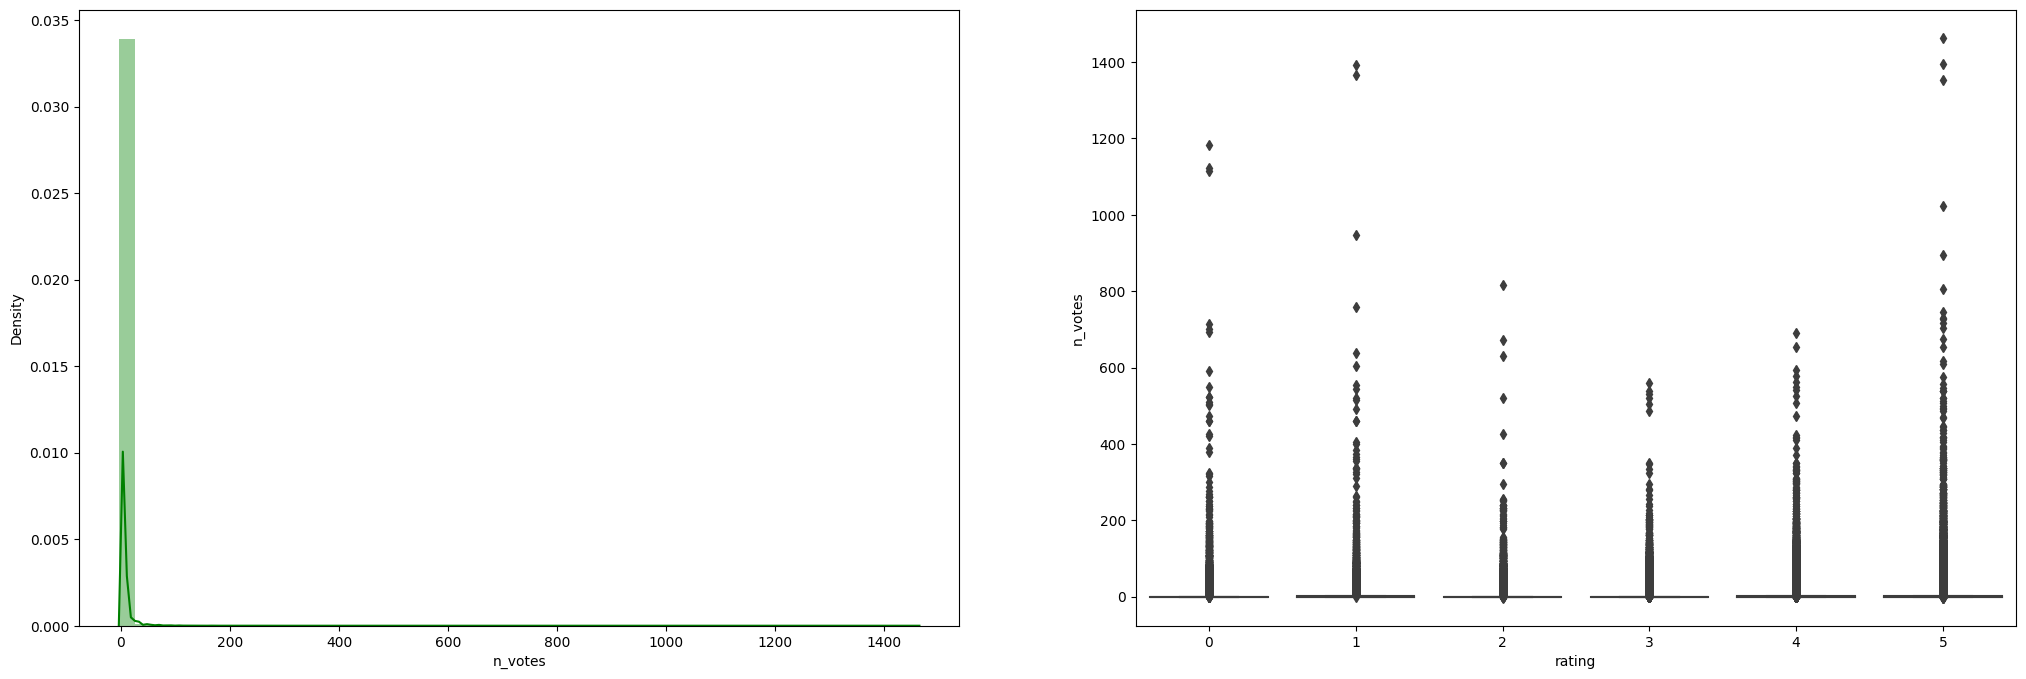

In [108]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['n_votes'], ax=axes[0], color='green')
sns.boxplot(y= 'n_votes', data=df_books_users, ax=axes[1],  x='rating')
plt.show()

Observation:

We can see that 90% of the data has less than 2 votes, most the books got 0 votes.
This feature is not useful, we will drop it.

In [35]:
df_books_users.drop(columns=['n_votes'], inplace=True)

### num_pages

compute the nth percentile of the data along the specified axis. In simple terms, a percentile is a measure that indicates the value below which a given percentage of observations in a group of observations falls.

In [110]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['num_pages'], i))

0th percentile is 0.0
10th percentile is 100.0
20th percentile is 176.0
30th percentile is 224.0
40th percentile is 256.0
50th percentile is 281.0
60th percentile is 311.0
70th percentile is 341.0
80th percentile is 382.0
90th percentile is 440.0
100th percentile is 945077.0



A more detailed look at the lower 10% of the 'num_pages' distribution:

In [111]:
for i in range(0, 11, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['num_pages'], i))

0th percentile is 0.0
1th percentile is 24.0
2th percentile is 32.0
3th percentile is 32.0
4th percentile is 36.0
5th percentile is 40.0
6th percentile is 48.0
7th percentile is 63.0
8th percentile is 76.0
9th percentile is 90.0
10th percentile is 100.0


A detailed look at the upper 10% of the 'num_pages' distribution.

In [112]:
for i in range(90, 101, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['num_pages'], i))

90th percentile is 440.0
91th percentile is 448.0
92th percentile is 464.0
93th percentile is 476.0
94th percentile is 494.0
95th percentile is 512.0
96th percentile is 544.0
97th percentile is 590.0
98th percentile is 660.0
99th percentile is 767.0
100th percentile is 945077.0


99% of the books have less than 767 pages.

In [113]:
print('num_pages >=55000 :-   ', df_books_users[df_books_users['num_pages']>=55000.0]['num_pages'].count())
print('num_pages <=4 :-       ', df_books_users[(df_books_users['num_pages']<=4)]['num_pages'].count())

num_pages >=55000 :-    4
num_pages <=4 :-        11349


In [36]:
df_books_users = df_books_users[df_books_users['num_pages']>4]

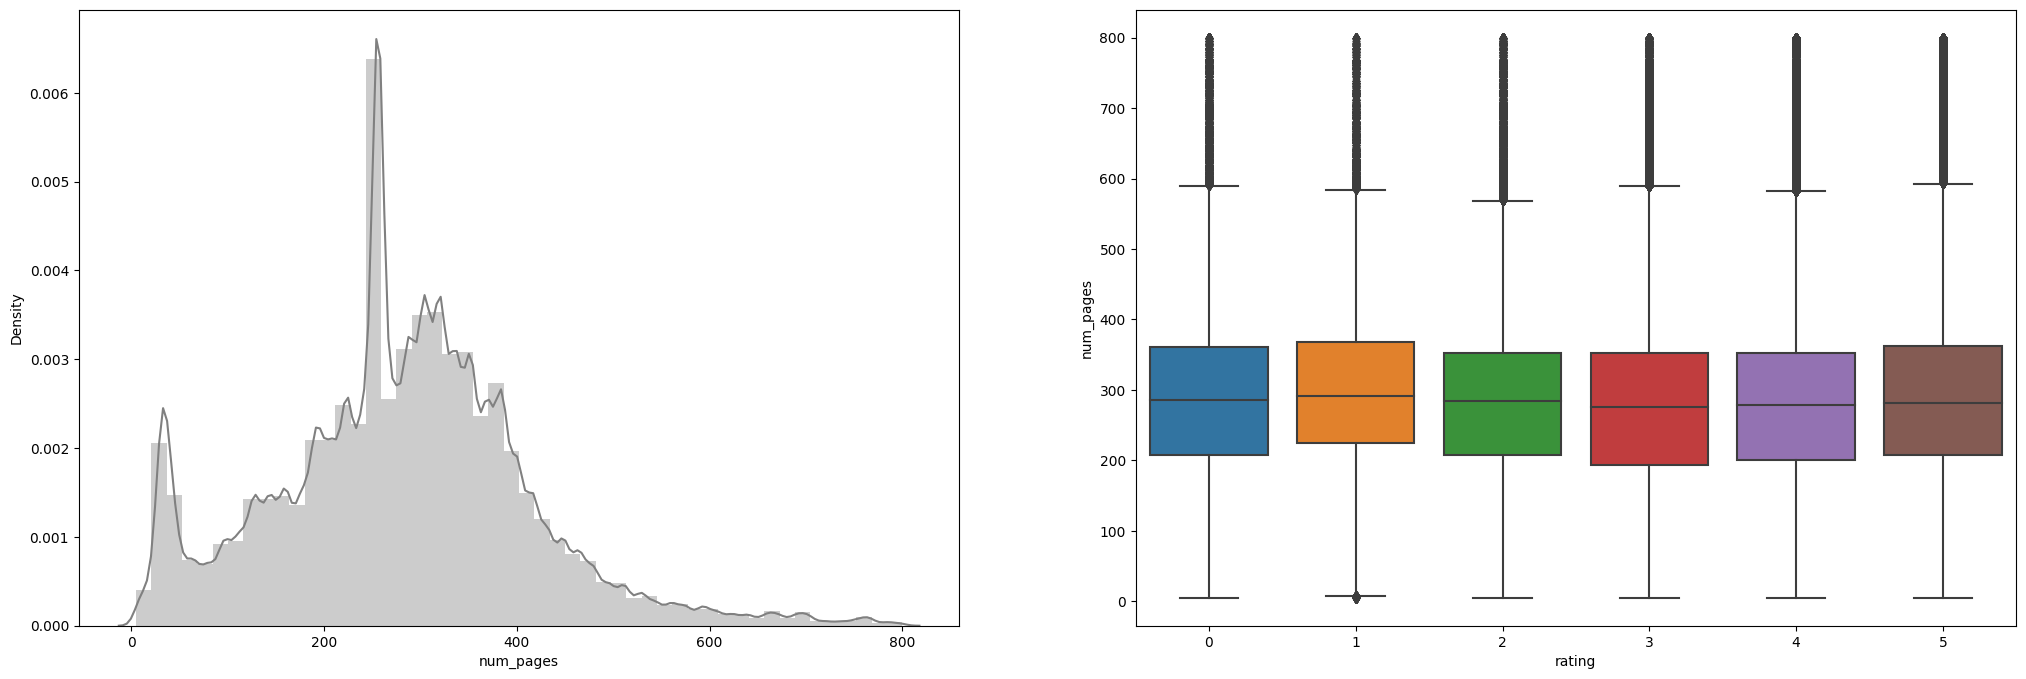

In [115]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
filter_data = df_books_users[df_books_users['num_pages']<=800.0]
sns.distplot(filter_data['num_pages'], ax=axes[0], color='grey')
sns.boxplot(y= 'num_pages', data=filter_data[(filter_data['average_rating']>2.6) & (filter_data['average_rating']<4.8)] , ax=axes[1],  x='rating')
plt.show()

Observation:

99% of the books have less than 767 pages.
There are 4 books which have >= 55000 pages, they are the oxford dictionary, wikipedia translated books.They could have those number of pages, we cannot drop them.
There are nearly 11349 books which have <=4 pages, this is absurd.These are outliers we will drop them.

### publication_year

In [116]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['publication_year'], i))

0th percentile is 1.0
10th percentile is 2002.0
20th percentile is 2007.0
30th percentile is 2009.0
40th percentile is 2011.0
50th percentile is 2012.0
60th percentile is 2013.0
70th percentile is 2014.0
80th percentile is 2015.0
90th percentile is 2016.0
100th percentile is 21016.0


In [117]:
for i in range(90, 101, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['publication_year'], i))

90th percentile is 2016.0
91th percentile is 2016.0
92th percentile is 2016.0
93th percentile is 2016.0
94th percentile is 2016.0
95th percentile is 2016.0
96th percentile is 2017.0
97th percentile is 2017.0
98th percentile is 2017.0
99th percentile is 2017.0
100th percentile is 21016.0


In [118]:
for i in range(0, 11, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['publication_year'], i))

0th percentile is 1.0
1th percentile is 1982.0
2th percentile is 1989.0
3th percentile is 1992.0
4th percentile is 1995.0
5th percentile is 1997.0
6th percentile is 1998.0
7th percentile is 1999.0
8th percentile is 2000.0
9th percentile is 2001.0
10th percentile is 2002.0


In [119]:
print('publication_year <1850.0 :-   ', df_books_users[df_books_users['publication_year']<1850.0]['publication_year'].count())
print('publication_year >2022.0 :-   ', df_books_users[df_books_users['publication_year']>2022.0]['publication_year'].count())

publication_year <1850.0 :-    683
publication_year >2022.0 :-    370


In [37]:
df_books_users = df_books_users[(df_books_users['publication_year']>=1850.0)]
df_books_users = df_books_users[(df_books_users['publication_year']<=2022.0)]

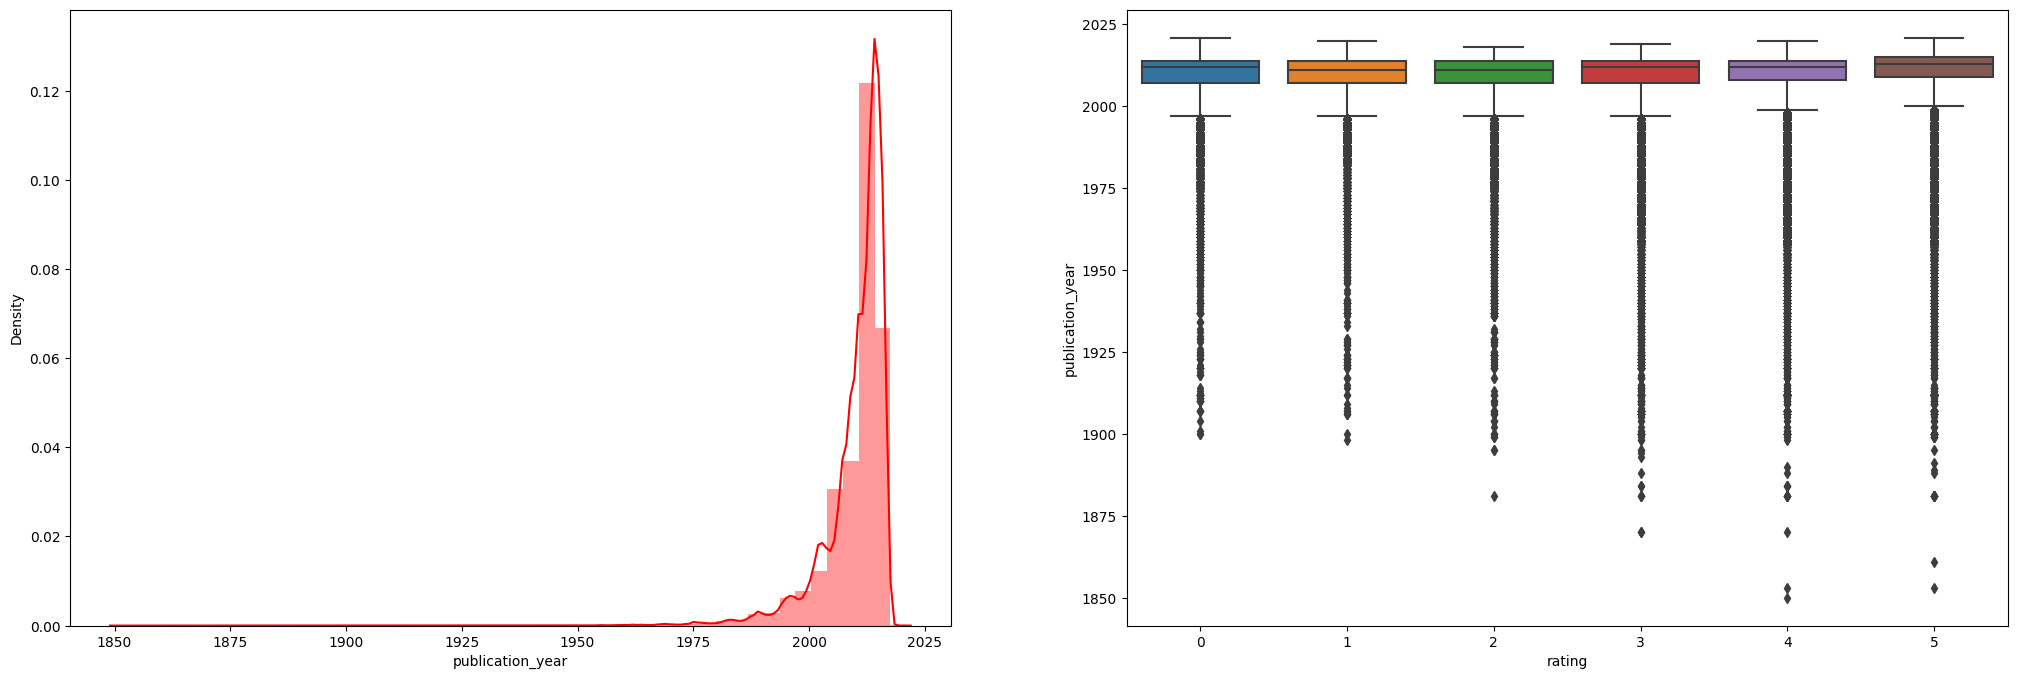

In [121]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['publication_year'], ax=axes[0], color='red')
sns.boxplot(y= 'publication_year', data=df_books_users[(df_books_users['average_rating']>2.6) & (df_books_users['average_rating']<4.8)] , ax=axes[1],  x='rating')
plt.show()

Observation:

There were some outliers, publication_year for some books was >2022 and there were some books where publication year<1850.
We removed the outlier data points from our dataset.

### book_average_rating

In [122]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['average_rating'], i))

0th percentile is 1.0
10th percentile is 3.49
20th percentile is 3.65
30th percentile is 3.76
40th percentile is 3.85
50th percentile is 3.93
60th percentile is 4.0
70th percentile is 4.09
80th percentile is 4.18
90th percentile is 4.3
100th percentile is 5.0


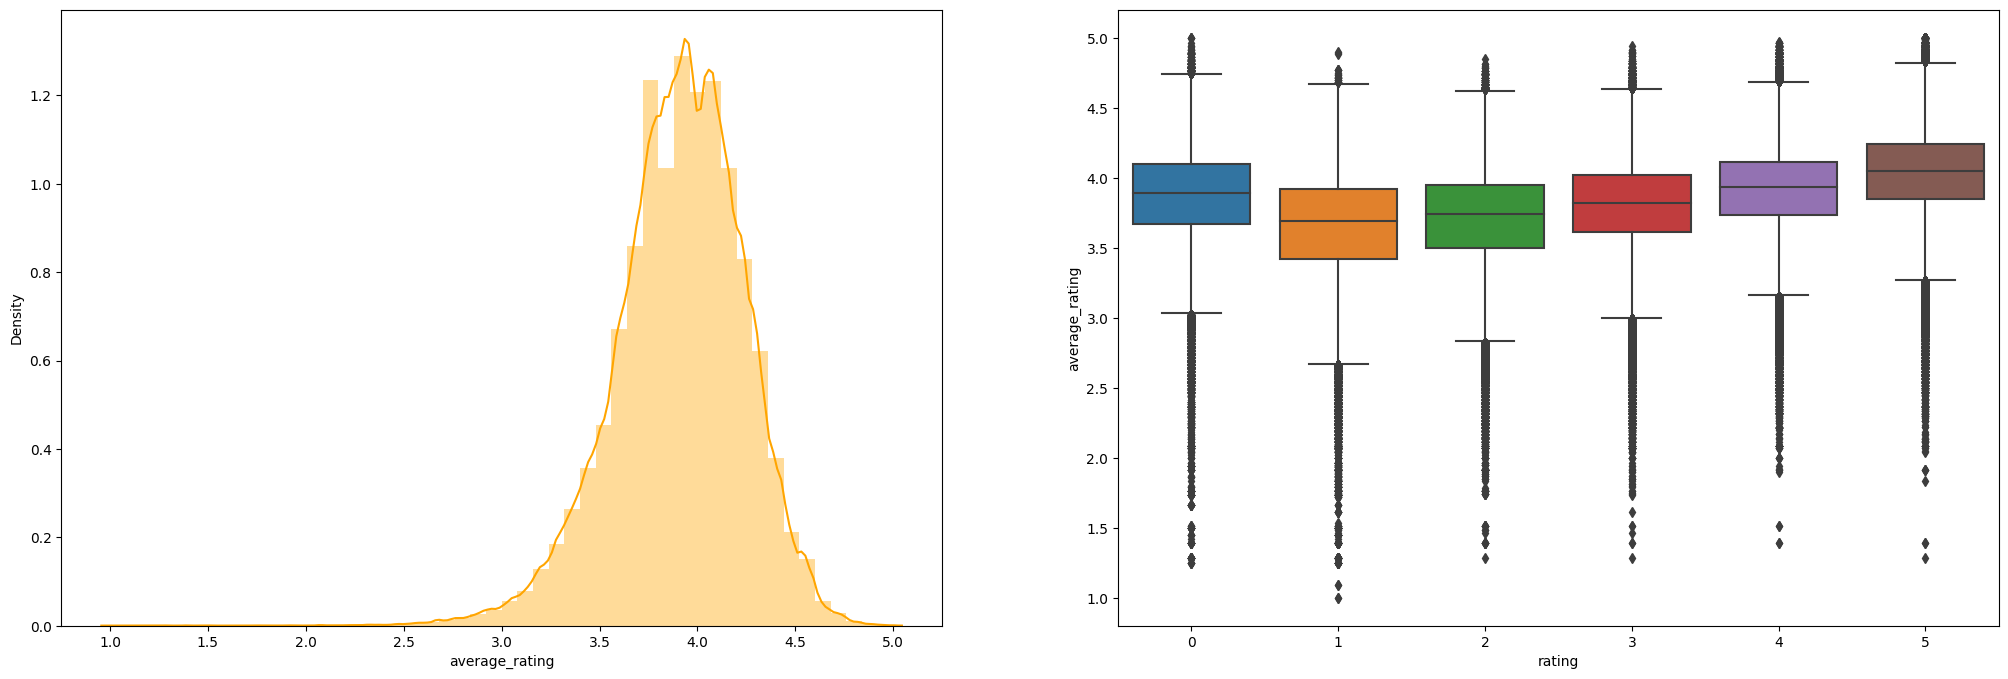

In [123]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['average_rating'], ax=axes[0], color='orange')
sns.boxplot(y= 'average_rating', data=df_books_users, ax=axes[1],  x='rating')
plt.show()

Observation:

We can see that majority of books have got average rating of 3.8 and there are very few books which has very high and low average-rating, which is expected.
We cannot drop the books in any range on this feature.

### is_ebook

In [124]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['is_ebook'], i))

0th percentile is 0.0
10th percentile is 0.0
20th percentile is 0.0
30th percentile is 0.0
40th percentile is 0.0
50th percentile is 0.0
60th percentile is 0.0
70th percentile is 0.0
80th percentile is 0.0
90th percentile is 1.0
100th percentile is 1.0


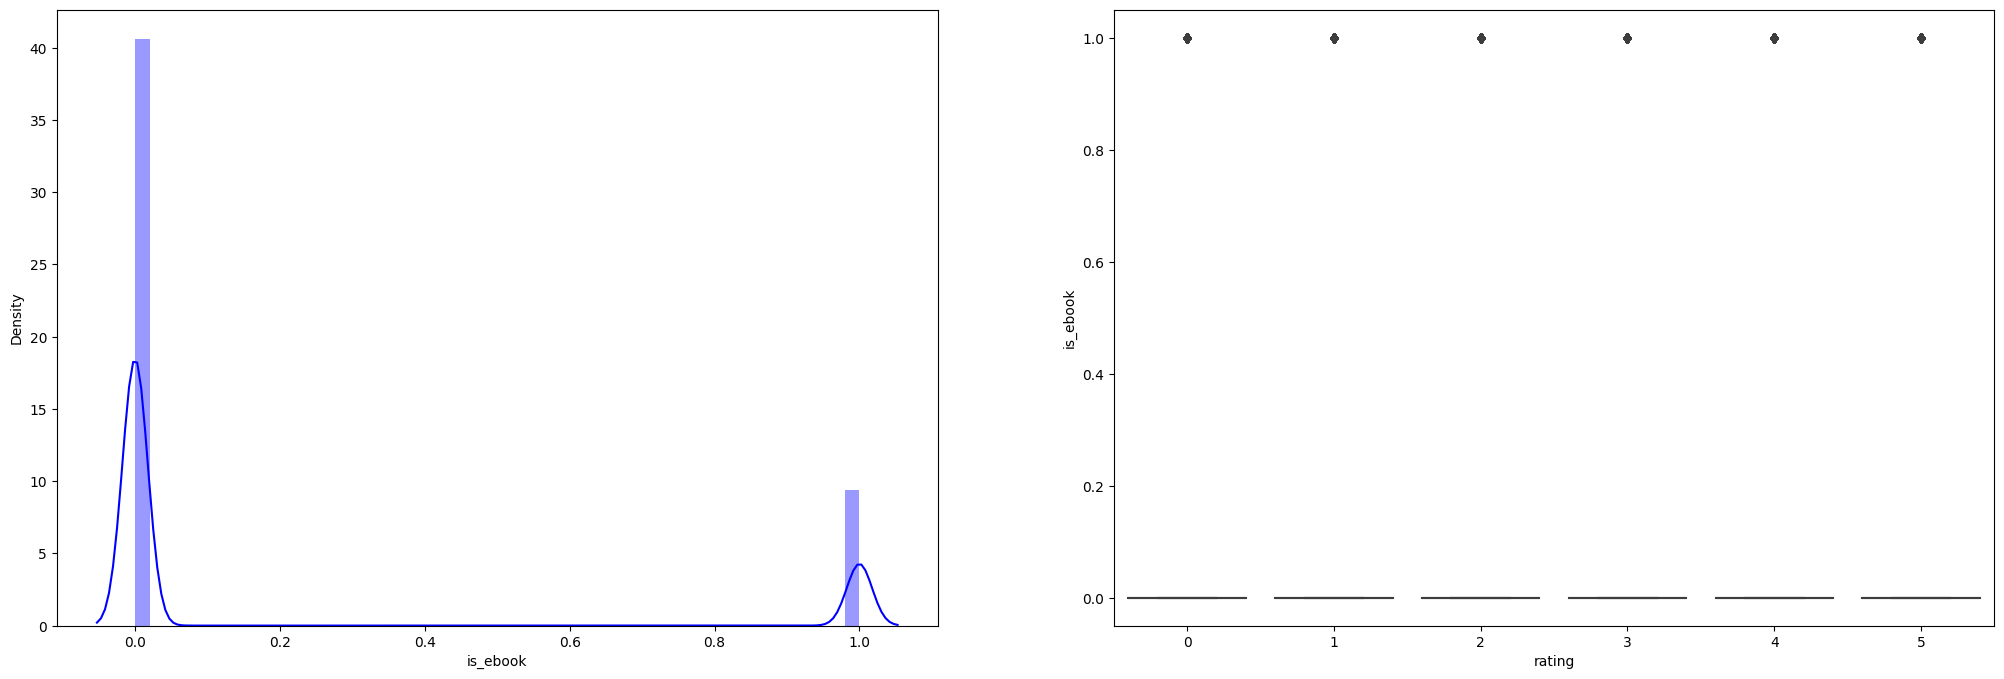

In [125]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['is_ebook'], ax=axes[0], color='blue')
sns.boxplot(y= 'is_ebook', data=df_books_users[(df_books_users['average_rating']>2.6) & (df_books_users['average_rating']<4.8)], ax=axes[1],  x='rating')
plt.show()

Observation:

We can see that 80% of books are paper books and only 20% paper books.
is_ebook seems to be useful feature as it has distribution of 80-20 over two different categories, probably it will help.

### ratings_count

In [126]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['ratings_count'], i))

0th percentile is 16.0
10th percentile is 42.0
20th percentile is 88.0
30th percentile is 174.0
40th percentile is 332.0
50th percentile is 624.0
60th percentile is 1190.0
70th percentile is 2384.0
80th percentile is 5474.0
90th percentile is 17746.0
100th percentile is 748926.0


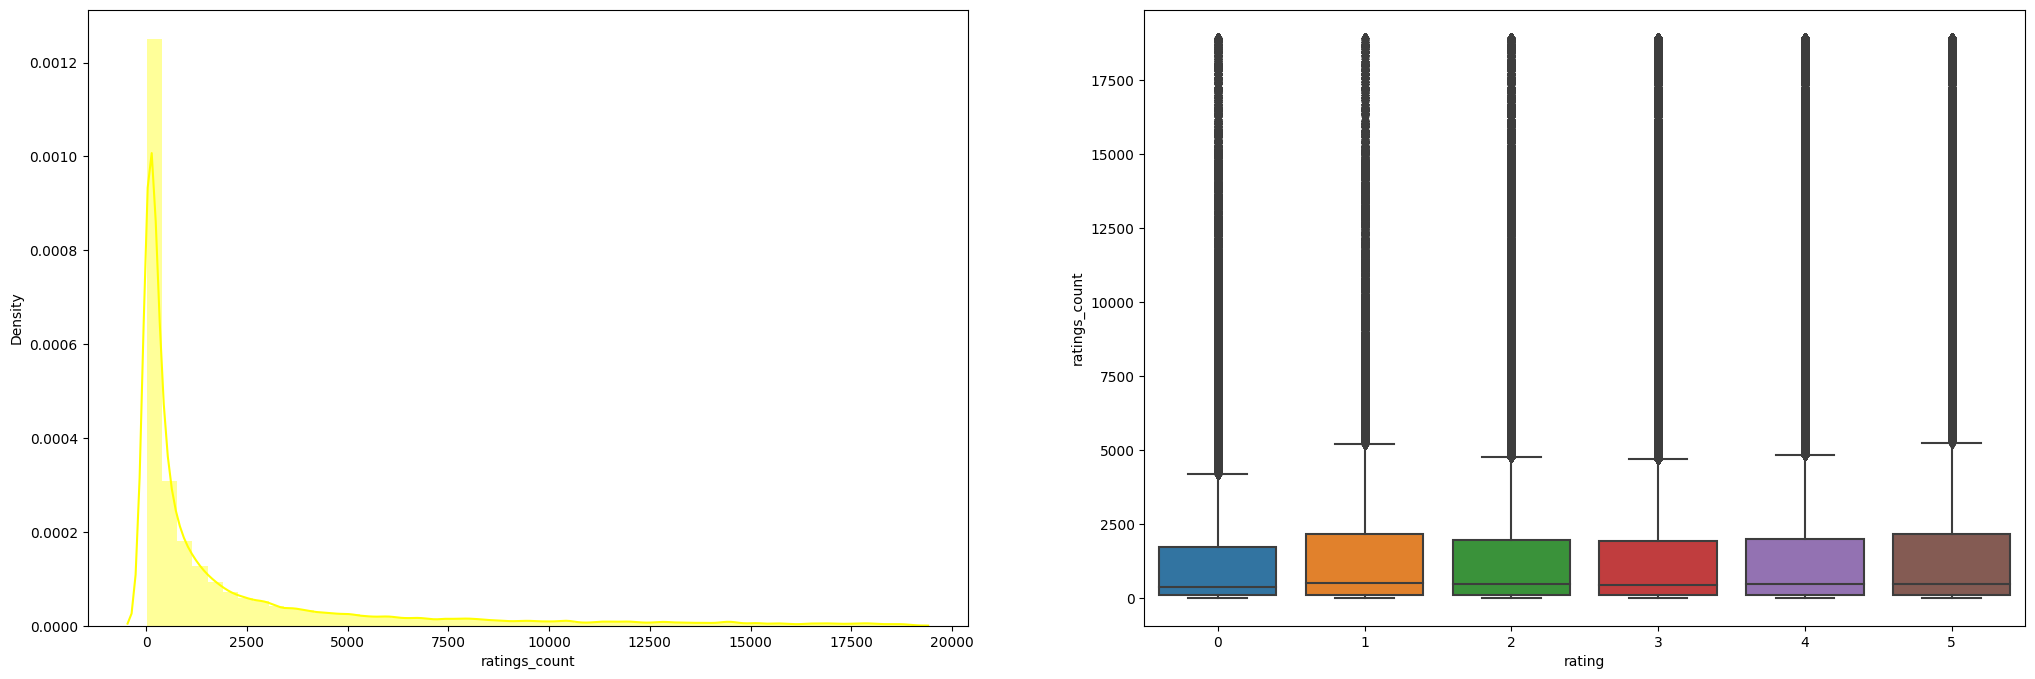

In [127]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
filter_data = df_books_users[df_books_users['ratings_count']<=18935.0]
sns.distplot(filter_data['ratings_count'], ax=axes[0], color='yellow')
sns.boxplot(y= 'ratings_count', data=filter_data[(filter_data['average_rating']>2.6) & (filter_data['average_rating']<4.8)] , ax=axes[1],  x='rating')
plt.show()

Observation:

90% of books has been rated by less than 17746 users.
Data is distributed across all user_rating, we will keep it.

### Visualization through count plot and distplot

Distplot_plotter: It shows the variation in the data distribution corresponding to different features

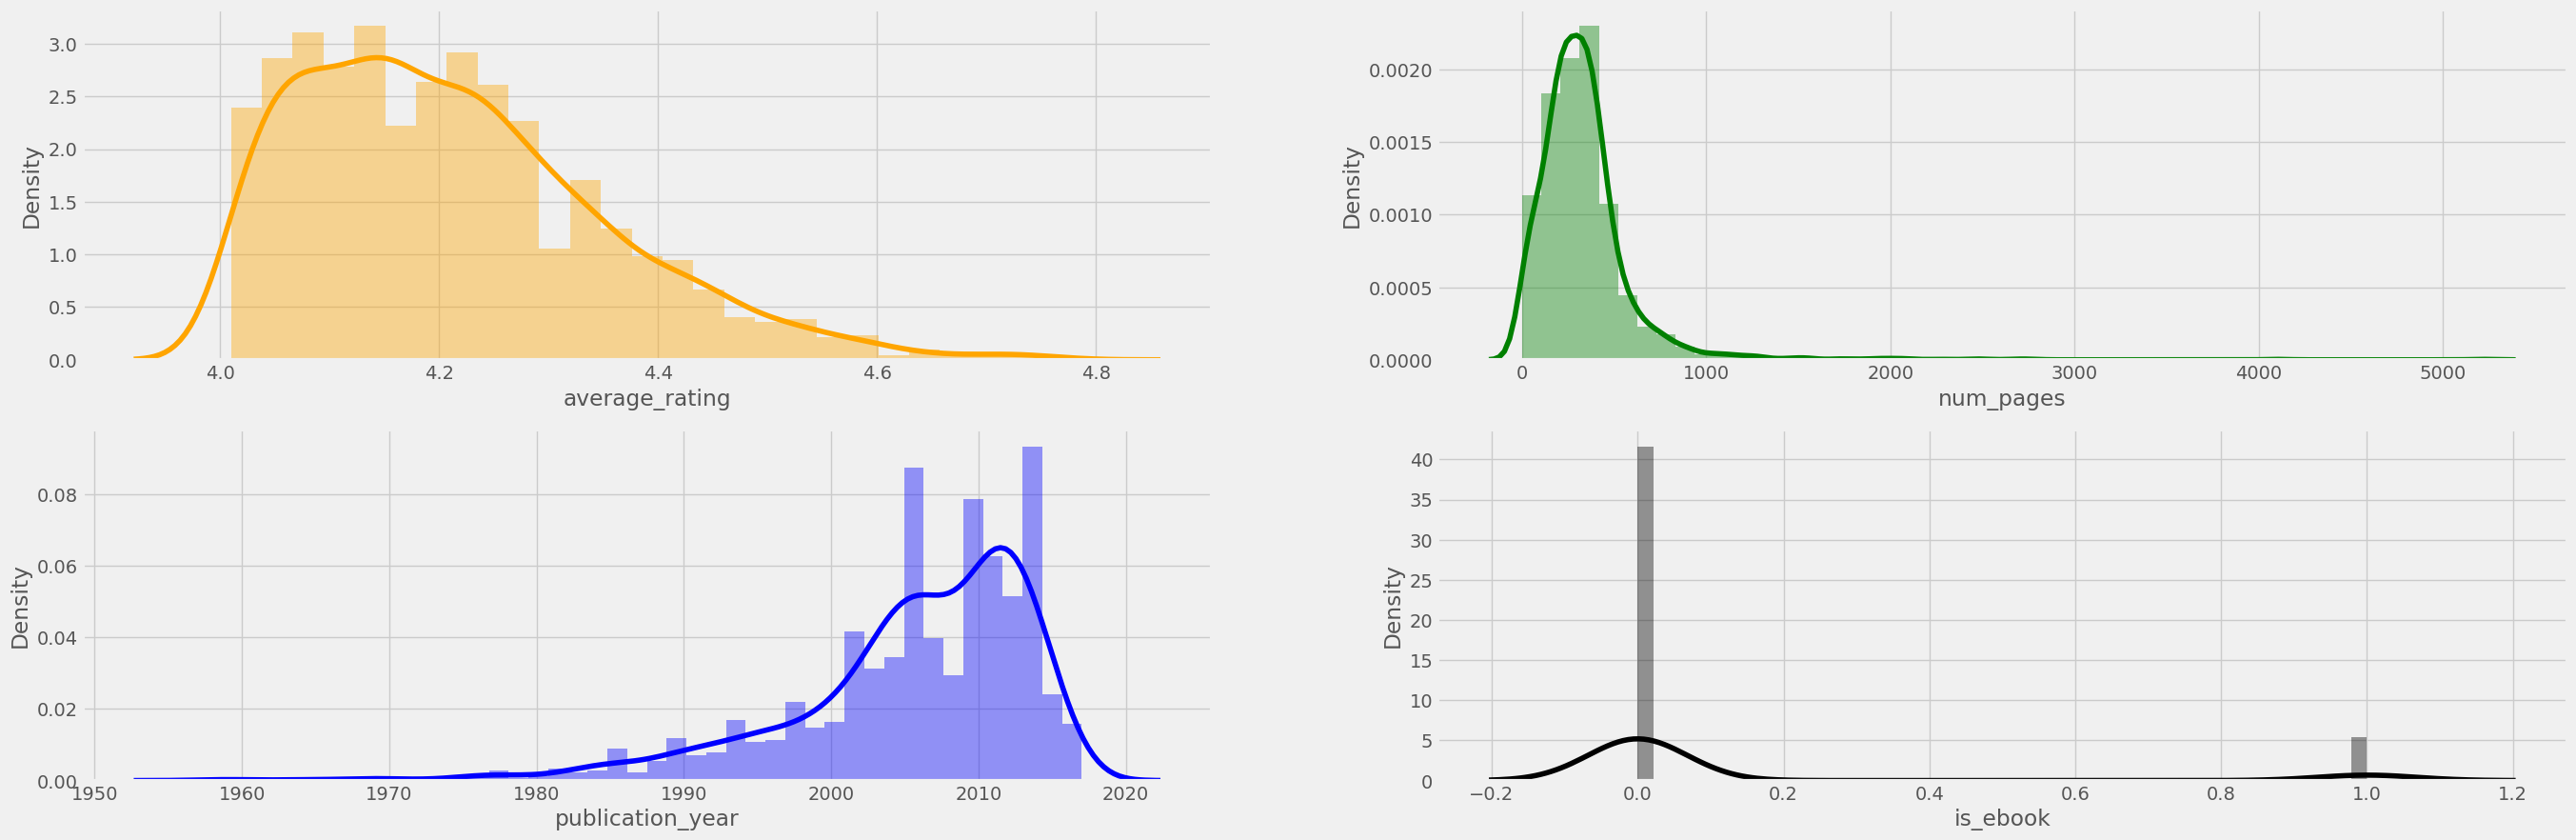

In [232]:
filtered_dataset = df_books_processed[(df_books_processed['average_rating']>4.0) & (df_books_processed['ratings_count']>8000) & (df_books_processed['publication_year']>1950)]


figure, axes = plt.subplots(2, 2, figsize=(30,10))
sns.distplot(filtered_dataset['average_rating'], ax=axes[0,0], label='Average Rating on Books', color='orange')
sns.distplot(filtered_dataset['num_pages'], ax=axes[0,1], label='Number of Pages in Books',color="green")
sns.distplot(filtered_dataset['publication_year'], ax=axes[1,0], label='Publication Year of Books',color="blue")
sns.distplot(filtered_dataset['is_ebook'], ax=axes[1,1], label='E-Book/Paper Book',color="black")
plt.show()

Countplot_plotter: It shows the count of different categories present in data.

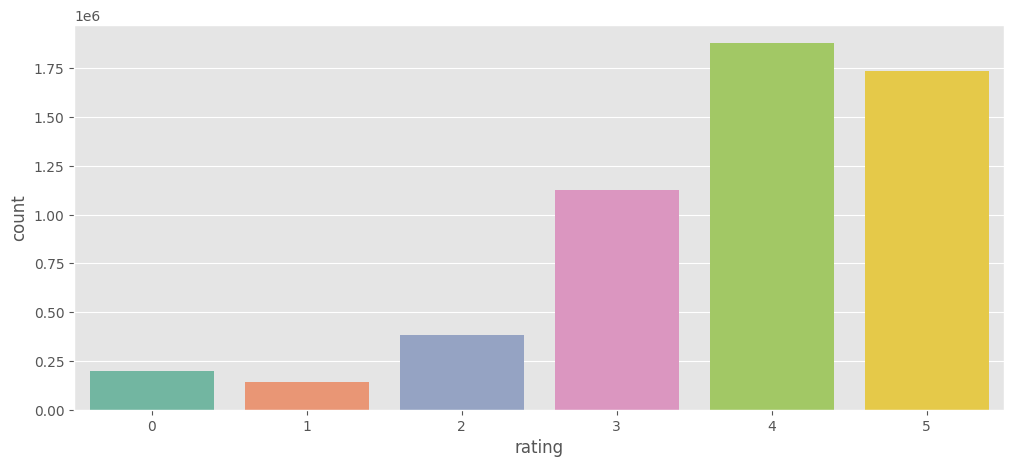

In [129]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
sns.countplot(data = df_books_users, x= 'rating', palette='Set2')
plt.show()

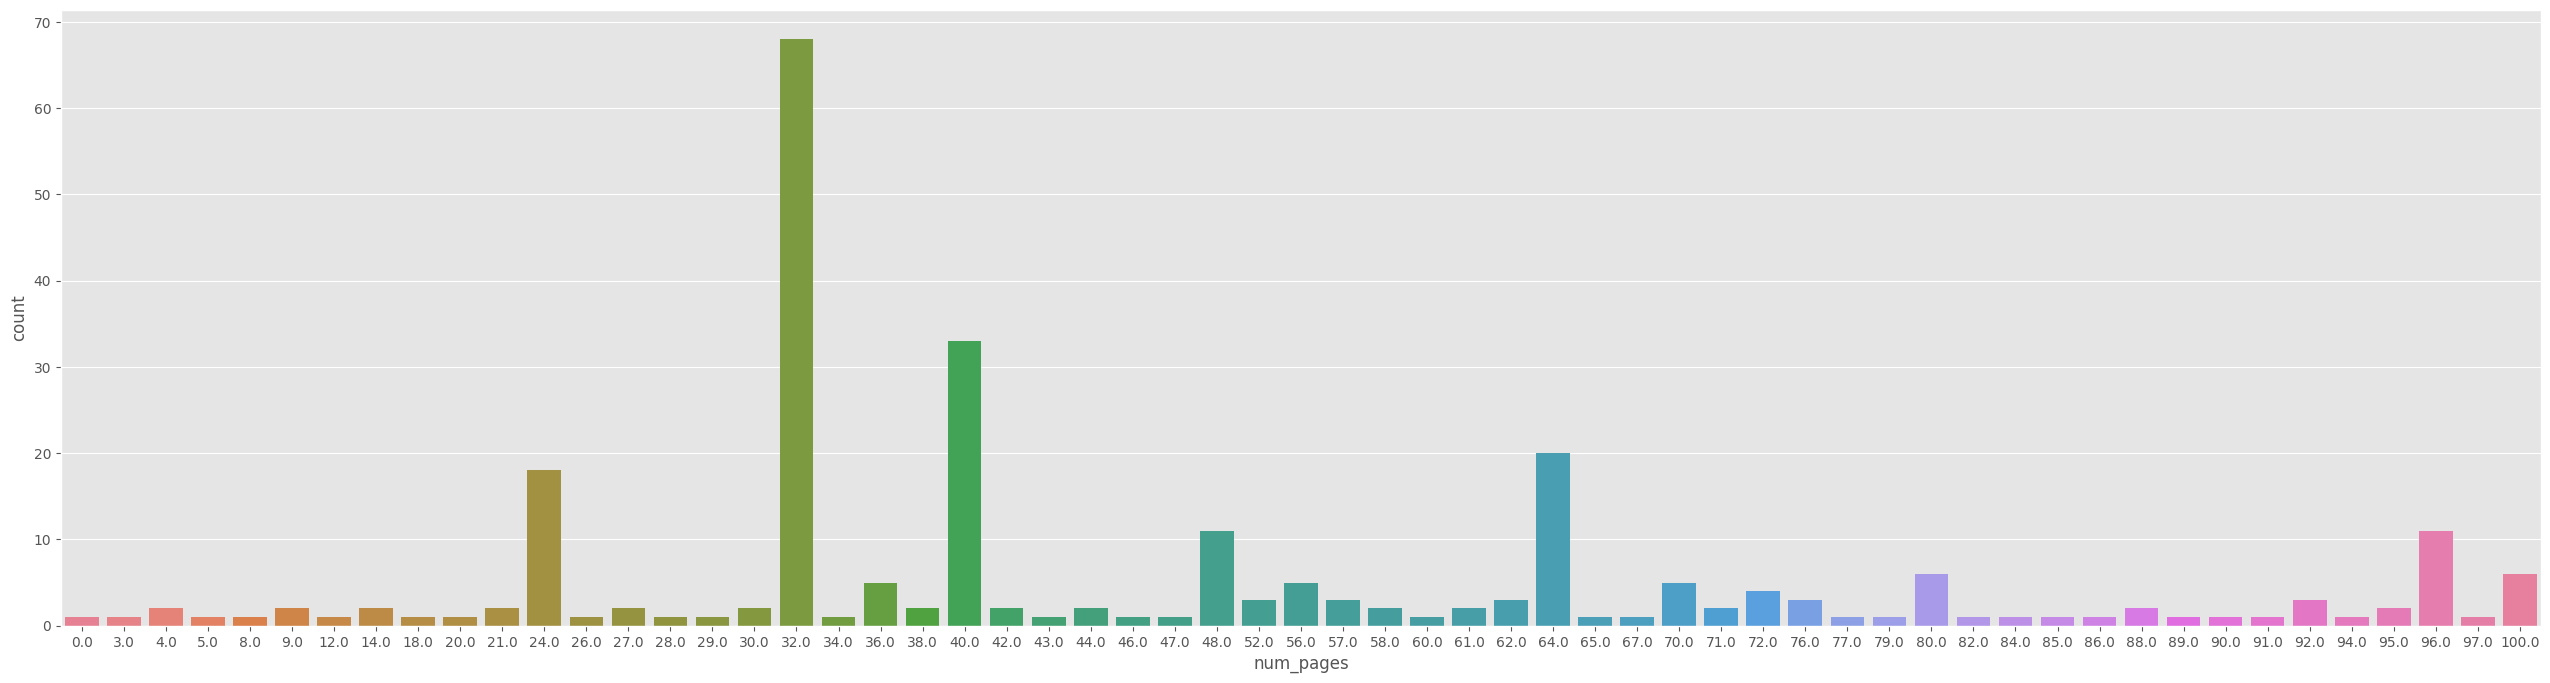

In [130]:
plt.style.use('ggplot')
plt.figure(figsize=(32, 8))
sns.countplot(data=filtered_dataset[filtered_dataset['num_pages']<=100] , x='num_pages', palette='husl')
plt.show()

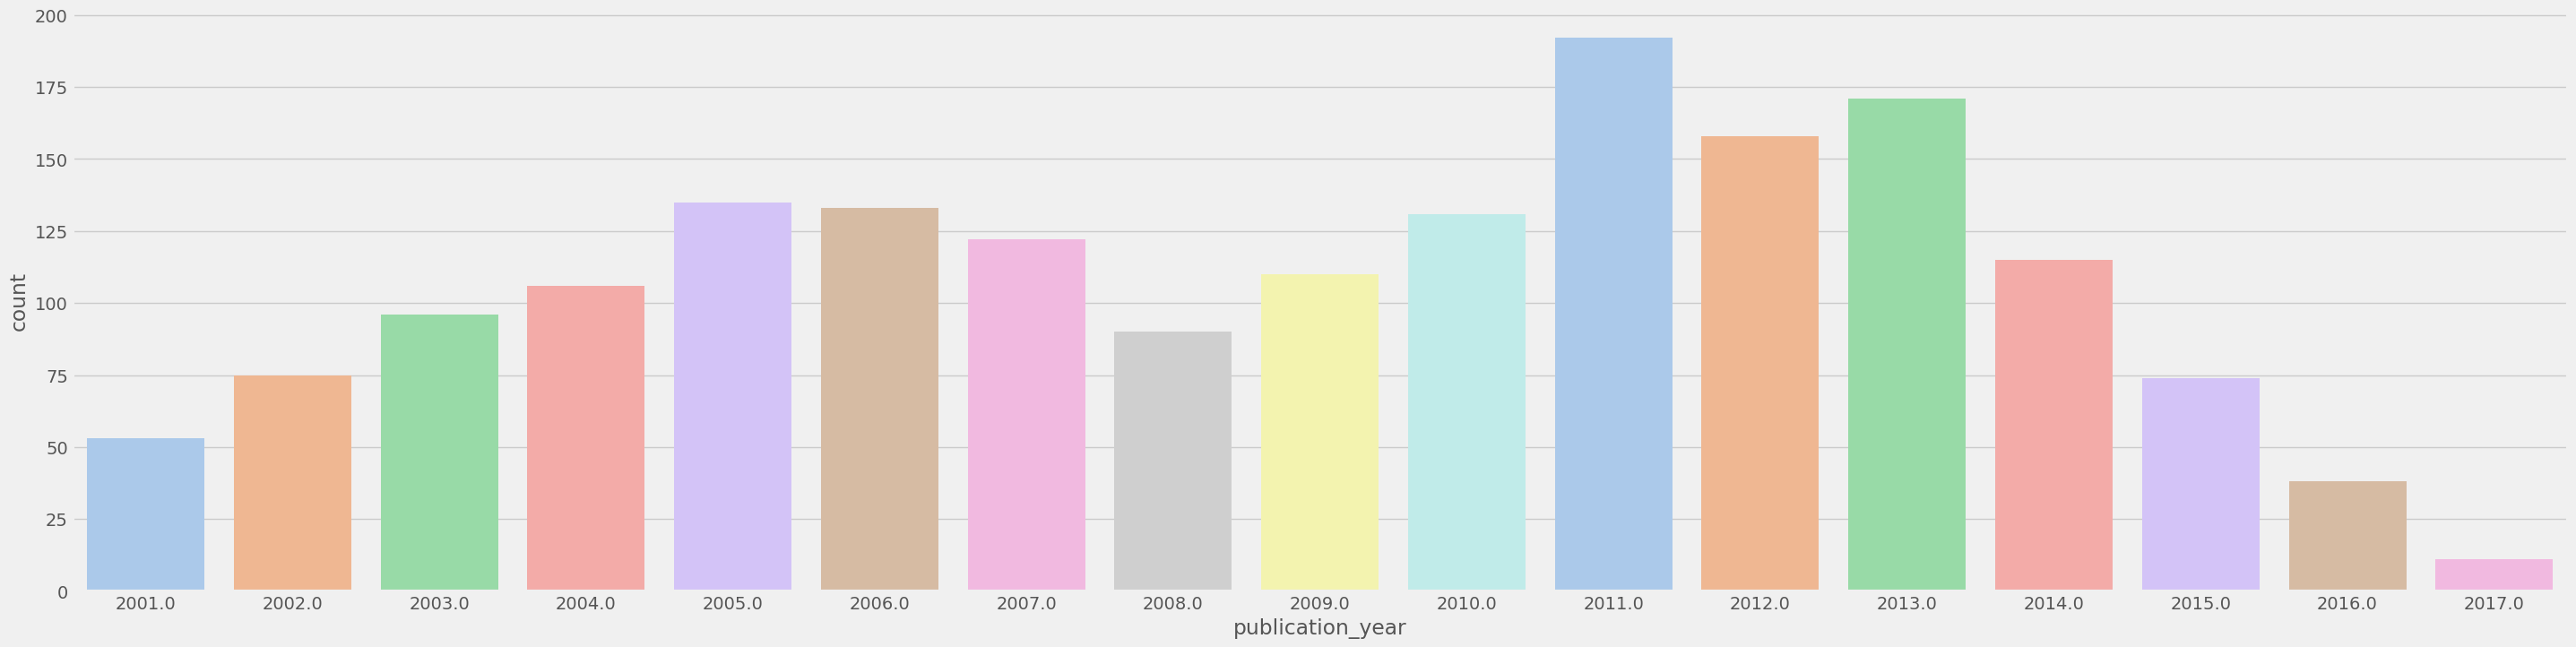

In [131]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(32, 8))
sns.countplot(data=filtered_dataset[filtered_dataset['publication_year']>2000] , x='publication_year', palette='pastel')
plt.show()

### Correlation Analysis between each numeric feature

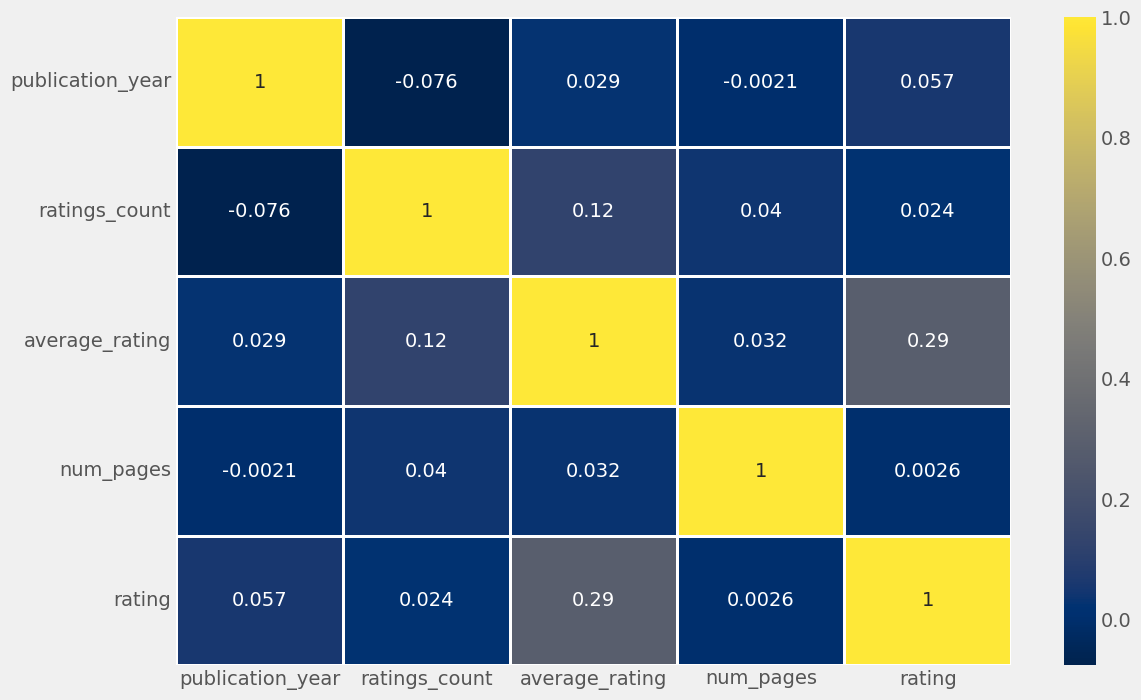

In [132]:
cormat = df_books_users[['publication_year', 'ratings_count', 'average_rating', 'num_pages', 'rating']].corr()
round(cormat,2)
plt.figure(figsize=(12, 8))
sns.heatmap(cormat, cmap='cividis', annot=True, linewidths=2)
plt.show()

### Saving df_books_users_processed dataframe

In [38]:
df_books_users_processed = df_books_users
df_books_users_processed.to_csv(books_users_path_processed_csv, index=False, compression='gzip')

In [39]:
df_books_users_processed.isnull().any()

book_id                 False
title_without_series    False
description             False
publication_year        False
publisher               False
ratings_count           False
average_rating          False
image_url               False
url                     False
is_ebook                False
num_pages               False
mod_title               False
user_id                 False
review_text             False
rating                  False
dtype: bool

In [5]:
df_books_processed = pd.read_csv(books_path_processed_csv)
df_books_users_processed = pd.read_csv(books_users_path_processed_csv)

In [10]:
df_books_users_processed = df_books_users_processed.dropna(axis=0)
df_books_processed = df_books_processed[df_books_processed['mod_title'].notnull()]

In [11]:
df_books_processed.to_csv(books_path_processed_csv, index=False, compression='gzip')
df_books_users_processed.to_csv(books_users_path_processed_csv, index=False, compression='gzip')

Conclusion:

There are 2079758 books in df_users_processed and 678274 books in df_books_processed.We merged the two dataframes on 'book_id', by making inner merge.After merge operation we are remaining with only books for which we have information in both df_books and df_users dataframe.
We have 3,28,596 users remaining in final dataframe, df_books_users.
We have 6,59,411 books in final dataframe, df_books_users.
We have 54,67,457 data points (users rating on books) with 15 features avaialble.
Features are:

- book_id
- title_without_series
- description
- publication_year
- publisher
- ratings_count
- average_rating
- image_url
- url
- is_ebook
- num_pages
- mod_title

# First Cut Solution

### Top 50 books with best book_average_rating

We will filter the dataset and will only limit it to books that received an average rating of≥4.5 and rating_count>8000 users.

top_book_average_rating: This function is created to perform filteration in above given range.Additionally it also saves the top 50 average rated books.

Ratings_count

In [137]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_processed['ratings_count'], i))

0th percentile is 16.0
10th percentile is 20.0
20th percentile is 26.0
30th percentile is 34.0
40th percentile is 45.0
50th percentile is 61.0
60th percentile is 86.0
70th percentile is 131.0
80th percentile is 226.0
90th percentile is 529.0
100th percentile is 748926.0


In [138]:
for i in range(90, 101):
  print(f'{i}th percentile is', np.percentile(df_books['ratings_count'], i))

90th percentile is 638.0
91th percentile is 729.0
92th percentile is 843.0
93th percentile is 992.0
94th percentile is 1193.0
95th percentile is 1481.0
96th percentile is 1911.7600000000093
97th percentile is 2650.0
98th percentile is 4138.0
99th percentile is 8469.0
100th percentile is 4899965.0


On average 50% of books are rated by 61 users

These are highest rated books in among top 3% highly rated movies by users



In [139]:
def top_book_average_rating():
  top50_highest_rated_books = df_books_processed[(df_books_processed['average_rating']>=4.50) & (df_books_processed['ratings_count']>3000.0)].sort_values(by='average_rating', ascending=False)
  top50_highest_rated_books[:50].to_csv(top50_highest_rated_books_path, index=False)
  return top50_highest_rated_books[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

top_book_average_rating()

,book_id,title_without_series,average_rating,image_url,url
452486,11221285,"The Way of Kings, Part 2 (The Stormlight Archive #1.2)",4.780000,,Goodreads
671971,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.770000,,Goodreads
199975,165068,The Jesus Storybook Bible: Every Story Whispers His Name,4.750000,,Goodreads
605764,24814,It's a Magical World: A Calvin and Hobbes Collection,4.750000,,Goodreads
231169,70489,There's Treasure Everywhere: A Calvin and Hobbes Collection,4.740000,,Goodreads


### Top 50 highly-rated books by Number of pages in Books.

We will filter the dataset and will only limit it to books that contain≤300 pages and possess a rating of ≥4.5 and rating_count of ≥8000 users.

top_concised_books: This function is created to perform filteration in above given range.Additionally it also saves the top 50 concised_books.

In [140]:
df_books['num_pages'].describe()

count    937378.000000
mean        280.252306
std        1002.116670
min           0.000000
25%         170.000000
50%         263.000000
75%         356.000000
max      945077.000000
Name: num_pages, dtype: float64

In [141]:
def top_concised_books():
  top_50_concised_books = df_books_processed[(df_books_processed['num_pages']<=300)& (df_books_processed['ratings_count']>3000.0)&(df_books_processed['average_rating']>=4.50)].sort_values(by='average_rating', ascending=False)
  top_50_concised_books.to_csv(top50_concised_books_path, index=False)
  return top_50_concised_books[['book_id', 'title_without_series', 'num_pages', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

top_concised_books()

,book_id,title_without_series,num_pages,average_rating,image_url,url
605764,24814,It's a Magical World: A Calvin and Hobbes Collection,176.000000,4.750000,,Goodreads
231169,70489,There's Treasure Everywhere: A Calvin and Hobbes Collection,176.000000,4.740000,,Goodreads
605765,24815,The Indispensable Calvin and Hobbes,255.000000,4.730000,,Goodreads
231170,70487,Attack of the Deranged Mutant Killer Monster Snow Goons,127.000000,4.720000,,Goodreads
107090,121792,The Revenge of the Baby-Sat,128.000000,4.710000,,Goodreads


### Top 50 highly-rated books by Paper-Book vs E-Book choices.



We can see that 'is_ebook' is useful feature, as among highly rated books it books that are not e-book has more percentage

It was found that the majority of books were paper books so will filter the dataset and will only limit it to books that are available as paper books and possess a rating of ≥4.5 and rating_count of ≥8000 users.

top_50_paper_books: This function is created to perform filteration in above given range.Additionally it also saves the top 50 paper_book

Note: We see that the recommendation of books we obtained when we looked at top books by average book rating and top books which are available as paper books are the same. This assures that the majority of top books are paper books.s.

In [142]:

def top_50_paper_books():
  df_ebook = df_books_processed[(df_books_processed['average_rating']>=4.5) & (df_books_processed['ratings_count']>3000.0)].sort_values(by='average_rating', ascending=False)
  top_50_paper_books = df_ebook[df_ebook['is_ebook']==False]
  top_50_paper_books.to_csv(top50_paper_books_path, index=False)
  return top_50_paper_books[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

top_50_paper_books()

,book_id,title_without_series,average_rating,image_url,url
452486,11221285,"The Way of Kings, Part 2 (The Stormlight Archive #1.2)",4.780000,,Goodreads
671971,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.770000,,Goodreads
199975,165068,The Jesus Storybook Bible: Every Story Whispers His Name,4.750000,,Goodreads
605764,24814,It's a Magical World: A Calvin and Hobbes Collection,4.750000,,Goodreads
231169,70489,There's Treasure Everywhere: A Calvin and Hobbes Collection,4.740000,,Goodreads


In [143]:
def top_50_e_books():
  df_ebook = df_books_processed[(df_books_processed['average_rating']>=4.5) & (df_books_processed['ratings_count']>3000.0)].sort_values(by='average_rating', ascending=False)
  top_50_e_books = df_ebook[df_ebook['is_ebook']==True]
  top_50_e_books.to_csv(top50_e_books_path, index=False)
  return top_50_e_books[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

top_50_e_books()

,book_id,title_without_series,average_rating,image_url,url
619838,16029144,"The Outlander Series (Outlander, #1-7)",4.730000,,Goodreads
503496,15803693,"Clockwork Angel; Clockwork Prince; Clockwork Princess (The Infernal Devices, #1-3)",4.680000,,Goodreads
497866,18713259,Worm,4.670000,,Goodreads
118183,15842007,The Fever Series,4.650000,,Goodreads
229911,19233301,"The King (The Original Sinners, #6)",4.640000,,Goodreads


### Top 50 highly-rated books having Similar Title.

We will use the Tf-IDF scheme to convert each book title into a numeric vector. We will then find the cosine similarity between the book titles in the dataset and the book title provided by the customer.

top_50_similar_title_books: This function is generate numeric vector corresponding to each book title using Tf-IDF scheme and find similarity between books. Additionally it also saves the top 50 similar title books.

In [42]:
vectorizer_title_fc = TfidfVectorizer()
tfidf_title_fc = vectorizer_title_fc.fit_transform(df_books_processed["mod_title"])

In [43]:
with open('content/vectorizer_title.pkl', 'wb') as p:
    dump(vectorizer_title_fc, p)

with open('content/tfidf_title.pkl', 'wb') as p:
    dump(tfidf_title_fc, p)    

with open("content/vectorizer_title.pkl", "rb") as p:
    vectorizer_title_fc = load(p)    

with open("content/tfidf_title.pkl", "rb") as p:
    tfidf_title_fc = load(p)   

In [146]:
def top_50_similar_title_books(vectorizer):
  query = str(input('Enter book title: '))
  processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
  query_vec = vectorizer.transform([query])
  similarity = cosine_similarity(query_vec, tfidf_title_fc).flatten()
  indices = np.argpartition(similarity, -50)[-50:]
  results = df_books_processed.iloc[indices]
  return results[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

top_50_similar_title_books(vectorizer_title_fc) 

Enter book title:  7


,book_id,title_without_series,average_rating,image_url,url
226050,12096412,Emmaus,3.260000,,Goodreads
226051,23565331,Incanta Soul-Catcher (Lost Souls #1),3.600000,,Goodreads
226053,18748788,As Fantásticas Aventuras de Dog Mendonça e Pizzaboy III: Requiem,4.190000,,Goodreads
226052,504974,Culture War? The Myth of a Polarized America (Great Questions in Politics Series),3.450000,,Goodreads
226054,4463739,A Class Act,3.320000,,Goodreads


### Books having similar description

We will use the Tf-IDF scheme to convert each book description into a numeric vector. We will then find the cosine similarity between the books in the dataset and the book description provided by the customer.

top_50_similar_description_books: This function is generate numeric vector corresponding to each book description using Tf-IDF scheme and find similarity between books. Additionally it also saves the top 50 similar description books.

In [44]:
vectorizer_description = TfidfVectorizer()
tfidf_description = vectorizer_description.fit_transform(df_books_processed["description"])

In [45]:
with open('content/vectorizer_description.pkl', 'wb') as p:
    dump(vectorizer_description, p)

with open('content/tfidf_description.pkl', 'wb') as p:
    dump(tfidf_description, p)    

with open("content/vectorizer_description.pkl", "rb") as p:
    vectorizer_description = load(p)    

with open("content/tfidf_description.pkl", "rb") as p:
    tfidf_description = load(p)

In [149]:
def search(vectorizer):
  query = str(input('Enter the Description: '))
  processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
  query_vec = vectorizer.transform([query])
  similarity = cosine_similarity(query_vec, tfidf_description).flatten()
  indices = np.argpartition(similarity, -50)[-50:]
  results = df_books_processed.iloc[indices]
  return results[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})
search(vectorizer_description) 

Enter the Description:  bla bla


,book_id,title_without_series,average_rating,image_url,url
435319,25409945,"Rebel Moon (Moonstruck, #2)",3.730000,,Goodreads
659509,36128671,Första hösten Blå gryning,4.250000,,Goodreads
607012,1690210,Så går en dag ifrån vårt liv och kommer aldrig åter,3.410000,,Goodreads
453723,9270518,"Blå måne (De Udødelige, #2)",3.610000,,Goodreads
198528,12617757,Systrar i Jeans (Systrar i Jeans #1),3.760000,,Goodreads


### Books that got similar review

We will use the Tf-IDF scheme to convert each book review into a numeric vector. We will then find the cosine similarity between the books in the dataset and the review of book id provided by the customer.

review_similarity: This function is generate numeric vector corresponding to each book review using Tf-IDF scheme and find similarity between books. Additionally it also saves the top 50 similar provided reviews.

In [46]:
data = list()
for book_id, df in tqdm(df_users[['book_id', 'review_text']].groupby('book_id')):
  data.append((book_id, list(df['review_text'])))

df_book_id_review = pd.DataFrame(data, columns =['book_id', 'list_review_text'])
df_book_id_review  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2079758/2079758 [01:42<00:00, 20321.30it/s]


,book_id,list_review_text
0,1,"[One of the best books in the series I think.,..."
1,10,"[good read, LOVED the Harry Potter books!, Har..."
2,100,[Some ideas were pretty fun and original!]
3,1000,"[There's a lot in this book that I enjoyed, be..."
4,10000,[This has not aged well. Of course I have only...
...,...,...
2079753,9999954,"[Dat zo'n Dijkshoorn op tv nog te pruimen is, ..."
2079754,9999969,[Over all a fun read. Every one of the stories...
2079755,9999986,"[Picking up ""Walking to the Stars,"" I didn't k..."
2079756,999999,[Fantastic]


In [47]:
df_book_id_review['book_id'] = df_book_id_review['book_id'].astype('int64')
df_final_review = df_book_id_review[df_book_id_review['book_id'].isin(set(df_books_processed['book_id']))]
df_final_review.reset_index(drop=True, inplace=True)

In [48]:
print(df_final_review)

         book_id                                   list_review_text
0            100         [Some ideas were pretty fun and original!]
1           1000  [There's a lot in this book that I enjoyed, be...
2          10000  [This has not aged well. Of course I have only...
3       10000009  [Cute! Great book for an emergent reader about...
4       10000014  [The mixed media art was very fun with this bo...
...          ...                                                ...
662161    999993  [You have heard of Hobson's choice which is no...
662162   9999934  [I like the story, but the pigs look like they...
662163   9999954  [Dat zo'n Dijkshoorn op tv nog te pruimen is, ...
662164   9999969  [Over all a fun read. Every one of the stories...
662165   9999995  [A man and a woman get married and have a baby...

[662166 rows x 2 columns]


In [49]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
preprocessed_reviews = list()
for sentences in tqdm(df_final_review['list_review_text'].values):
  mod_sentences = list()
  for sentence in sentences:
    try:
      sentence = re.sub(r"http\S+", "", sentence)
      sentence = decontracted(sentence)
      sentence = re.sub('[^A-Za-z]+', ' ', sentence[:500])
      sentence = BeautifulSoup(sentence, 'lxml').get_text()
     
      sentence = re.sub("\S*\d\S*", "", sentence).strip()
      sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
      mod_sentences.append(sentence.strip()) 
    except Exception as e:
      pass 
  preprocessed_reviews.append(mod_sentences) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662166/662166 [18:20<00:00, 601.81it/s]


In [51]:
review = [' '.join(lst) for lst in tqdm(preprocessed_reviews)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662166/662166 [00:01<00:00, 612998.30it/s]


In [52]:
df_final_review['combined_processed_review'] = review
df_final_review['preprocessed_reviews'] = preprocessed_reviews

In [53]:
vectorizer_review = TfidfVectorizer()
tfidf_review = vectorizer_review.fit_transform(df_final_review['combined_processed_review'])

In [54]:
with open('content/vectorizer_review.pkl', 'wb') as p:
    dump(vectorizer_review, p)

with open('content/tfidf_review.pkl', 'wb') as p:
    dump(tfidf_review, p)    

with open("content/vectorizer_review.pkl", "rb") as p:
    vectorizer_review = load(p)    

with open("content/tfidf_review.pkl", "rb") as p:
    tfidf_review = load(p)

In [55]:
df_final_review.to_csv(final_review_path, compression='gzip', index=False)

In [56]:
print(df_final_review)

         book_id                                   list_review_text  \
0            100         [Some ideas were pretty fun and original!]   
1           1000  [There's a lot in this book that I enjoyed, be...   
2          10000  [This has not aged well. Of course I have only...   
3       10000009  [Cute! Great book for an emergent reader about...   
4       10000014  [The mixed media art was very fun with this bo...   
...          ...                                                ...   
662161    999993  [You have heard of Hobson's choice which is no...   
662162   9999934  [I like the story, but the pigs look like they...   
662163   9999954  [Dat zo'n Dijkshoorn op tv nog te pruimen is, ...   
662164   9999969  [Over all a fun read. Every one of the stories...   
662165   9999995  [A man and a woman get married and have a baby...   

                                combined_processed_review  \
0                               ideas pretty fun original   
1       lot book enjoyed 

In [162]:
def review_similarity():
  book_id = int(input('Enter the book_id: '))
  index = df_final_review[df_final_review['book_id']== book_id].index
  if len(index) == 0:   # check if index is empty
    print("No reviews found for the given book_id")
    return
  index = df_final_review[df_final_review['book_id']== book_id].index
  similarity = cosine_similarity(tfidf_review[index], tfidf_review).flatten()
  indices = np.argpartition(similarity, -50)[-50:]
  book_ids = set(df_final_review.iloc[indices]['book_id'])
  score = [(score, book) for score, book in enumerate(book_ids)]
  df_score = pd.DataFrame(score, columns =['score', 'book_id'])
  results = (df_books_processed[df_books_processed['book_id'].isin(book_ids)].merge(df_score, on='book_id')).sort_values(by='score')
  print('Entered book title: ', str(df_books_processed[df_books_processed['book_id']==(book_id)]['title_without_series'].values[0]).strip())
  return results[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url', 'ratings_count']].head(5).style.format(({'image_url': show_image, 'url': make_clickable}))

review_similarity()

Enter the book_id:  23017947


Entered book title:  Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,average_rating,image_url,url,ratings_count
15,26129284,"Ms. Marvel, #1: Super Famous, Part 1",4.250000,,Goodreads,443
9,27163013,"Ms. Marvel, Vol. 5: Super Famous",4.240000,,Goodreads,6471
32,22558726,"Ms. Marvel, #6: Healing Factor",4.440000,,Goodreads,1022
17,22558730,"Ms. Marvel, #7: Healing Factor, Part II",4.390000,,Goodreads,910
42,28677262,"Ms. Marvel, #5: Army of One, Part 2",4.350000,,Goodreads,193


### Top 50 highly-rated books where User’s Choice match. - no
We will build a recommendation system here such that the system will ask for customers user_id and it will find the top 5 highest rated books by them.Then we will find other customers who liked the same books and will make a count on other books that are most famous among them. Further, we generate a scoring criterion, this is just to avoid any biasing as it might be possible that the books which we get finally may be famous among these other customers only and not in general, so we will normalize the previous count on books with the rating count(no. of customers who rated the book).

This system recommendation might sound a bit confusing, but this is the first advanced system we have built so far in the post, please follow the code in the repository.

similar_user_df: This function asks for user id and returns the data frame which contains the information of books liked by other customers, who liked the same books as the customer. It also returns the set of liked books for further processing of next calls in sequence.

popular_recommendation:This function computes the score as discussed above and recommends the most potentional books to customers.


In [163]:
def similar_user_df(df_books_users):
  user_id = str(input("Enter the user_id: "))
  df_liked_books = df_books_users[df_books_users['user_id']==user_id]
  liked_books = set(df_liked_books['book_id'])
  top_5_liked_books = df_liked_books.sort_values(by='rating', ascending=False)['book_id'][:5]
  similar_user = df_books_users[(df_books_users['book_id'].isin(top_5_liked_books))& (df_books_users['rating']>4)]['user_id']
  data = df_books_users[(df_books_users['user_id'].isin(similar_user))][['user_id', 'book_id', 'rating', 'ratings_count','title_without_series', 'average_rating', 'image_url', 'url']]
  return data, liked_books        

def popular_recommendation(recs, liked_books):
  all_recs = recs["book_id"].value_counts()
  all_recs = all_recs.to_frame().reset_index()
  all_recs.columns = ["book_id", "book_count"]
  all_recs = all_recs.merge(recs, how="inner", on="book_id")
  all_recs["score"] = all_recs["book_count"] * (all_recs["book_count"] / all_recs["ratings_count"])
  popular_recs = all_recs.sort_values("score", ascending=False)
  popular_recs_unbiased = popular_recs[~popular_recs["book_id"].isin(liked_books)].drop_duplicates(subset=['title_without_series'])
  popular_recs_unbiased.to_csv('popular_recs.csv', index=False)
  return popular_recs_unbiased[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url', 'ratings_count']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

recs, liked_books = similar_user_df(df_books_users)
popular_recommendation(recs, liked_books)

Enter the user_id:  fcddf0227aafbf744a7714ac4409d373


,book_id,title_without_series,average_rating,image_url,url,ratings_count
653,23017947,"Ms. Marvel, Vol. 2: Generation Why",4.140000,,Goodreads,17597
1200,23546843,"Ms. Marvel, Vol. 3: Crushed",4.210000,,Goodreads,13311
1738,25066780,"Ms. Marvel, Vol. 4: Last Days",4.250000,,Goodreads,9604
35604,16002160,Marvel Masterworks: Captain Marvel - Volume 1,3.230000,,Goodreads,16
2419,27163013,"Ms. Marvel, Vol. 5: Super Famous",4.240000,,Goodreads,6471


### Similiar Cover-Image of Books

Filtering out books that have missing cover pages

In [164]:
df_books_with_cover_page = df_books_processed[~df_books_processed['image_url'].str.contains("https://s.gr-assets.com/assets/nophoto")]

In [212]:
df_books_with_cover_page.to_csv('content/df_books_with_cover_page.csv')

Multiprocessing for parallelizing jobs

Saving images from provided book's cover page url

In [208]:
import logging
import time
from multiprocessing import Process

import pandas
import requests
from PIL import Image
from io import BytesIO

# make this be read only once 
print("Starting reading df_books_with_cover_page.csv")
df_books_with_cover_page = pandas.read_csv('content/df_books_with_cover_page.csv')
print("Finished reading df_books_with_cover_page.csv")

def setup_logger(logger_name, log_file, level=logging.INFO):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter('%(asctime)s : %(message)s')
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)

    l.setLevel(level)
    l.addHandler(fileHandler)

def process_images(start_index, end_index, logger_name, folder_name):
    start_time = time.time()

    print(f"Started process for logger {logger_name}")
    setup_logger(logger_name, f'logs/{logger_name}.log')
    logger = logging.getLogger(logger_name)
    for index, row in (df_books_with_cover_page[start_index:end_index].iterrows()):
        url = row['image_url']
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.save(f'content/{folder_name}_image/' + str(row['book_id']) + '.jpeg')
            logger.info(f"Saved image {row['book_id']}")
        except Exception as e:
            logger.error(f"Error with image {row['book_id']}: {e}")

    end_time = time.time()
    logger.info(f"Time taken: {end_time - start_time} seconds")
    print(f"Finished process for logger {logger_name}")

def main():
    num_processes = 8  # Number of processes
    processes = []

    rows = df_books_with_cover_page.shape[0]
    process_range = rows // num_processes  # Compute number of rows per process

    for i in range(num_processes):
        start_index = i * process_range
        if i == num_processes - 1:  # The last process needs to go to the end of the dataframe
            end_index = rows
        else:
            end_index = start_index + process_range
        process = Process(target=process_images, args=(start_index, end_index, f'log{i+1}', f'folder{i+1}_image'))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()

if __name__=="__main__":
    main()


In [209]:
print(df_books_with_cover_page.shape[0])

471614


Observation:

Above code took nearly 90 minutes on TPU

Transfer Learning(VGG16): Extracting feature vectors from saved cover page of books

Transfer Learning(VGG16): Extracting feature vectors from saved cover page of books

In [218]:
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(95, 140, 3))
model_new = Model(model_vgg16.input, model_vgg16.layers[-1].output)

def process_images_in_folder(folder_name):
    mapper = dict()
    folder_path = os.path.join('content', folder_name)
    image_files = os.listdir(folder_path)

    logging.info(f"Processing images in folder: {folder_name}")
    for image_path in tqdm(image_files):
        try:
            full_image_path = os.path.join(folder_path, image_path)

            image = load_img(full_image_path, target_size=(95, 140))
            image = img_to_array(image)
            image = preprocess_input(image)

            bottleneck_features = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
            mapper[image_path.split('.')[0]] = bottleneck_features
        except Exception as e:
            logging.error(f"Error processing image {image_path}. Reason: {e}")

    pkl_filename = os.path.join('content', f"{folder_name}.pkl")
    try:
        with open(pkl_filename, 'wb') as p:
            dump(mapper, p)
        logging.info(f"Saved data for {folder_name} to {pkl_filename}")
    except Exception as e:
        logging.error(f"Error saving data for {folder_name}. Reason: {e}")


folders = [
    "folder1_image", "folder2_image", "folder3_image",
    "folder4_image", "folderfive_image", "foldersix_image",
    "folderseven_image", "foldereight_image"
]

def main():
    # Setting up logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    for i in range(1, 9):
        folder = f"folder{i}_image"
        process_images_in_folder(folder)
        
    # f1 - 3:25:39<00:00,  4.74it/s
    # f2 - 1:10:21<00:00, 13.85it/s
    # f3 - 45:41<00:00, 14.34it/s
    # f4 - 41:53<00:00, 15.64it/s
    # f5 - 1:00:42<00:00, 16.04it/s
    # f6 - 1:00:24<00:00, 16.12it/s
    # f7 - 44:22<00:00, 14.67it/s
    # f8 - 43:45<00:00, 14.98it/s

Loading saved features

In [219]:
mapper1 = load(open("content/folder1_image.pkl", "rb"))
mapper2 = load(open("content/folder2_image.pkl", "rb"))
mapper3 = load(open("content/folder3_image.pkl", "rb"))
mapper4 = load(open("content/folder4_image.pkl", "rb"))
mapper5 = load(open("content/folder5_image.pkl", "rb"))
mapper6 = load(open("content/folder6_image.pkl", "rb"))
mapper7 = load(open("content/folder7_image.pkl", "rb"))
mapper8 = load(open("content/folder8_image.pkl", "rb"))

Translating features vector dimensions

In [221]:
mapper1 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper1.items()))
mapper2 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper2.items()))
mapper3 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper3.items()))
mapper4 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper4.items()))
mapper5 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper5.items()))
mapper6 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper6.items()))
mapper7 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper7.items()))
mapper8 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper8.items()))

Merging all dictionaries, creating dataframe

In [222]:
merge = {**mapper1, **mapper2, **mapper3, **mapper4, **mapper5, **mapper6, **mapper7, **mapper8}
df_image = pd.DataFrame(list(merge.items()), columns=['book_id', 'features'])
features = np.squeeze(np.array(list(df_image['features'])), axis=1)
df_image['book_id'] = df_image['book_id'].astype(int)

In [223]:
def get_similar_books_cnn():
  book_id = int(input('Enter the book_id: '))
  index = df_image[df_image['book_id']== book_id].index
  pairwise_dist = pairwise_distances(features, features[index].reshape(1,-1), metric='cosine')
  indices = list(np.argsort(pairwise_dist.flatten())[0:5])
  book_ids = list(df_image.loc[indices]['book_id'])
  score = [(score, book) for score, book in enumerate(book_ids)]
  df_score = pd.DataFrame(score, columns =['score', 'book_id'])
  similar_books= (df_books_processed[df_books_processed['book_id'].isin(book_ids)].merge(df_score, on='book_id')).sort_values(by='score')
  print('Entered book title: ', str(df_books_processed[df_books_processed['book_id']==int(book_id)]['title_without_series'].values[0]).strip())
  return similar_books[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

get_similar_books_cnn()

Enter the book_id:  23017947


Entered book title:  Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,average_rating,image_url,url
3,23017947,"Ms. Marvel, Vol. 2: Generation Why",4.140000,,Goodreads
0,27251104,"Ms. Marvel, Vol. 2: Génération Y",4.140000,,Goodreads
1,22558726,"Ms. Marvel, #6: Healing Factor",4.440000,,Goodreads
4,31121362,"Ms. Marvel, Vol. 2: Questões Mil",4.140000,,Goodreads
2,299604,"Abracadanger (Scream Shop Pick Your Path, #1)",3.610000,,Goodreads


Correlation-Based Recommendation

In [224]:
user = df_books_users_processed['user_id'].value_counts().to_frame().reset_index()
user.columns = ['user_id', 'rating_count']
highly_active_users = user[user['rating_count']>300]['user_id']
highly_rated_books = df_books_processed[df_books_processed['ratings_count']>3000]['book_id']

In [229]:
def correlation_recommendation():
  confined_df_users_books = df_books_users_processed[(df_books_users_processed['user_id'].isin(highly_active_users)) & (df_books_users_processed['book_id'].isin(highly_rated_books))]
  confined_df_users_books_limited  = confined_df_users_books[['user_id', 'book_id', 'rating']]
  pivot_books = confined_df_users_books_limited.pivot(index='user_id', columns='book_id').rating
  book_id = int(input('Enter the book_id: '))
  pivot_book_id = pivot_books[book_id]
  scores = pivot_books.corrwith(pivot_book_id).to_frame().reset_index()
  scores.columns = ['book_id', 'pearson_score']
  scores.dropna(inplace=True)
  similar_books_to_given_book = (df_books_processed[df_books_processed['book_id'].isin(scores[scores['pearson_score']>0.0]['book_id'])].merge(scores[scores['pearson_score']>0.0], on='book_id')).sort_values(by='pearson_score', ascending=False)
  print('Title of book given by customer:', str(df_books_processed[df_books_processed['book_id']==book_id]['title_without_series'].values[0]).strip())
  return similar_books_to_given_book[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

correlation_recommendation()  

Enter the book_id:  23017947


Title of book given by customer: Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,average_rating,image_url,url
755,148875,"The Rising Force (Star Wars: Jedi Apprentice, #1)",3.850000,,Goodreads
576,9647908,"The Ideal Man (Buchanan-Renard, #9)",3.920000,,Goodreads
541,11889938,"Taken (Elvis Cole, #15; Joe Pike, #4)",4.170000,,Goodreads
530,3710603,Y: The Last Man - The Deluxe Edition Book One,4.360000,,Goodreads
528,16061340,"The Colossus Rises (Seven Wonders, #1)",3.840000,,Goodreads


# Content Based Filtering

Finding Tf-idf score for mod_title

In [12]:
vectorizer_title = TfidfVectorizer(max_df= 659408, min_df= 100,  stop_words='english')
vectorizer_title.fit(df_books_processed["mod_title"])
tfidf_title = vectorizer_title.transform(df_books_users_processed['mod_title'])
tfidf_title.shape

(5467411, 3808)

Cleaning review_text data


In [ ]:
def processing(review):
  sentence = re.sub(r"http\S+", "", review)
  sentence = decontracted(sentence)
  sentence = re.sub('[^A-Za-z]+', ' ', sentence[:500])
  sentence = BeautifulSoup(sentence, 'lxml').get_text()
  sentence = re.sub("\S*\d\S*", "", sentence).strip()
  sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
  return sentence

df_books_users_processed['review_text'] = df_books_users_processed['review_text'].apply(processing)

Finding Tf-idf score for review_text

In [ ]:
vectorizer_review = TfidfVectorizer(max_df= 659408, min_df= 500, stop_words='english')
vectorizer_review.fit(df_books_users_processed["review_text"])
tfidf_review = vectorizer_review.transform(df_books_users_processed['review_text'])
tfidf_review.shape

Saving necessary data

In [ ]:
with open('content/tfidf_title.pkl', 'wb') as p:
    dump(tfidf_title, p)
with open('content/vectorizer_title.pkl', 'wb') as p:
    dump(vectorizer_title, p)

with open('content/tfidf_review.pkl', 'wb') as p:
    dump(tfidf_review, p)
with open('content/vectorizer_review.pkl', 'wb') as p:
    dump(vectorizer_review, p)

Label Encoding categorical features

In [ ]:
try:
    le1 = preprocessing.LabelEncoder()
    le1.fit(df_books_users_processed['book_id'])
    df_books_users_processed['book_id_mapped'] = le1.transform(df_books_users_processed['book_id'])
except Exception as e:
    print("Error while processing book_id_mapped:", e)

In [ ]:
try:
    le4 = preprocessing.LabelEncoder()
    le4.fit(df_books_users_processed['publisher'])
    df_books_users_processed['publisher_mapped'] = le4.transform(df_books_users_processed['publisher'])
except Exception as e:
    print("Error while processing book_id_mapped:", e)

In [ ]:
try:
    le7 = preprocessing.LabelEncoder()
    le7.fit(df_books_users_processed['is_ebook'])
    df_books_users_processed['is_ebook_mapped'] = le7.transform(df_books_users_processed['is_ebook'])

except Exception as e:
    print("Error while processing book_id_mapped:", e)

In [ ]:
try:
    le9 = preprocessing.LabelEncoder()
    le9.fit(df_books_users_processed['user_id'])
    df_books_users_processed['user_id_mapped'] = le9.transform(df_books_users_processed['user_id'])

except Exception as e:
    print("Error while processing book_id_mapped:", e)

Saving necessary data

In [ ]:
with open('content/le1.pkl', 'wb') as p:
    dump(le1, p)
with open('content/le4.pkl', 'wb') as p:
    dump(le4, p)
with open('content/le7.pkl', 'wb') as p:
    dump(le7, p)
with open('content/le9.pkl', 'wb') as p:
    dump(le9, p) 

In [18]:
df_books_users_processed.to_csv('content/df_books_users_processed.csv.gz', index=False, compression='gzip')

start training

In [9]:
import pandas as pd
books_users_path_processed_csv = 'content/df_books_users_processed.csv.gz'
df_books_users_processed = pd.read_csv(books_users_path_processed_csv)

In [10]:
print(df_books_users_processed.head(1))

   book_id                               title_without_series  \
0  7327624  The Unschooled Wizard (Sun Wolf and Starhawk, ...   

                                         description  publication_year  \
0  omnibus book club edition containing the ladie...            1987.0   

              publisher  ratings_count  average_rating  \
0  nelson doubleday inc            140            4.03   

                                           image_url  \
0  https://images.gr-assets.com/books/1304100136m...   

                                                 url  is_ebook  num_pages  \
0  https://www.goodreads.com/book/show/7327624-th...         0      600.0   

                                mod_title                           user_id  \
0  unschooled wizard sun wolf starhawk 12  d202352e716421da4ef3f7937df7c3f7   

                                         review_text  rating  book_id_mapped  \
0  Competent. I'm sure I read the first half year...       3          270120   

   publisher_ma

Extracting useful features for model training

In [11]:
df_books_users_numeric = df_books_users_processed[['book_id_mapped', 'publisher_mapped', 'is_ebook_mapped', 'user_id_mapped', 'publication_year', 'ratings_count', 'average_rating', 'num_pages', 'rating']]

Input and Output data for model training

In [12]:
x = df_books_users_numeric.drop(columns=['rating'])
user_rating = df_books_users_numeric['rating']

Normalizing Data

In [13]:
norm = MinMaxScaler()
norm.fit(x) # learning min and max values
x_normalized = norm.transform(x) # transform to [0,1]

In [14]:
with open("content/norm.pkl", "wb") as p:
    dump(norm, p)   

Stacking all features

In [15]:
with open('content/tfidf_title.pkl', 'rb') as p:
    tfidf_title = load(p)

with open('content/tfidf_review.pkl', 'rb') as p:
    tfidf_review = load(p)

In [16]:
data_x = hstack((x_normalized, tfidf_title, tfidf_review))

Saving the prepared training dataset

In [17]:
scipy.sparse.save_npz('content/data_x.npz', data_x)
with open('content/user_rating.pkl', 'wb') as p:
    dump(user_rating, p)

Loading the dataset

In [3]:
data_x = scipy.sparse.load_npz('content/data_x.npz')

In [5]:
data_x = scipy.sparse.load_npz('content/data_x.npz')
with open("content/user_rating.pkl", "rb") as p:
    user_rating = load(p)  

Train-Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_x, user_rating, test_size=0.30, random_state=42)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

GridSearch on Logistic regression to find best suited parameters for model

In [12]:
# Define the pipeline
std_slc = StandardScaler(with_mean=False)  # with_mean=False since data_x is sparse
pca = PCA()
logistic_Reg = OneVsRestClassifier(LogisticRegression(max_iter=100))

pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('logistic_Reg', logistic_Reg)])

# Update the parameter grid
n_components = list(range(1, X_train.shape[1]+1, 10))  # You might want to increase the step size if the data is too large
C = np.logspace(-4, 4, 10)
penalty = ['l1', 'l2']

param_grid = {
    'logistic_Reg__estimator__penalty': penalty,
    'logistic_Reg__estimator__C': C,
    'logistic_Reg__estimator__solver': ['saga'],
    'logistic_Reg__estimator__class_weight': [None, 'balanced'],
    'pca__n_components': n_components
}

param_grid = {
    'logistic_Reg__estimator__penalty': penalty,
    'logistic_Reg__estimator__C': C,
    'logistic_Reg__estimator__solver': ['saga'],
    'logistic_Reg__estimator__class_weight': [None, 'balanced'],
    'pca__n_components': n_components
}

In [ ]:

# Adjust the verbose in GridSearchCV
clf_GS = GridSearchCV(pipe, param_grid, cv=2, scoring='f1_macro', verbose=10, n_jobs=-1)
clf_GS.fit(X_train, y_train)

# Print the best parameters
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__estimator__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__estimator__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])

# Training Score
original = y_train   
predicted_train = clf_GS.predict(X_train)
score_train = precision_score(original, predicted_train, average='macro')
print('Training Precision Score:', score_train)

# Testing Score
original = y_test   
predicted_test = clf_GS.predict(X_test)
score_test = precision_score(original, predicted_test, average='macro')
print('Testing Precision Score:', score_test)

Fitting 2 folds for each of 92560 candidates, totalling 185120 fits


Training model with best obtained Parameters

In [ ]:
clf_lr = OneVsRestClassifier(LogisticRegression(penalty=best_params['estimator__penalty'], solver=best_params['estimator__solver'], class_weight=best_params['estimator__class_weight']))
clf_lr.fit(X_train, y_train)

Evaluating scores obtained on trained model

In [ ]:
original = y_train   
predicted = clf_lr.predict(X_train.tocsr())
score = precision_score(original, predicted, average='macro')
score

In [ ]:
original = y_test   
predicted = clf_lr.predict(X_test.tocsr())
score = precision_score(original, predicted, average='macro')
score

Confusion Matrix for Precision Score

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,10))
plot_confusion_matrix(clf_lr, X_train, y_train, values_format='.3g', ax=axes[0], normalize='pred', cmap='gist_gray')  
plot_confusion_matrix(clf_lr, X_test, y_test, values_format='.3g', ax=axes[1], normalize='pred', cmap='gist_gray') 
axes[0].set_title('Train Precision score')
axes[1].set_title('Test Precision score') 
plt.show()

In [15]:
with open('content/clf_lr.pkl', 'wb') as p:
    dump(clf_lr, p)

GridSearch on DecisionTree to find best suited parameters for model

In [16]:
clf = DecisionTreeClassifier()
parameters = {'max_depth':[15, 17],'min_samples_split':[20]}
clf1 = GridSearchCV(clf, parameters, cv= 2, scoring='f1_macro', verbose=2, return_train_score=True, n_jobs=-1)
clf1.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 17], 'min_samples_split': [20]},
             return_train_score=True, scoring='f1_macro', verbose=2)

Finding best parameters for model

In [17]:
best_params = clf1.best_params_
print('Best parameters are: ', best_params)

Best parameters are:  {'max_depth': 17, 'min_samples_split': 20}


Training model with best obtained Parameters

In [18]:
clf_best = DecisionTreeClassifier(max_depth=20, min_samples_split=20)
clf_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=20)

Evaluating scores obtained on trained model

In [19]:
original = y_train   # max_depth=20, min_samples_split=20
predicted = clf_best.predict(X_train.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.5159574398219384

In [20]:
original = y_test   # max_depth=20, min_samples_split=20
predicted = clf_best.predict(X_test.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.4587336960395936

Confusion Matrix for Precision Score

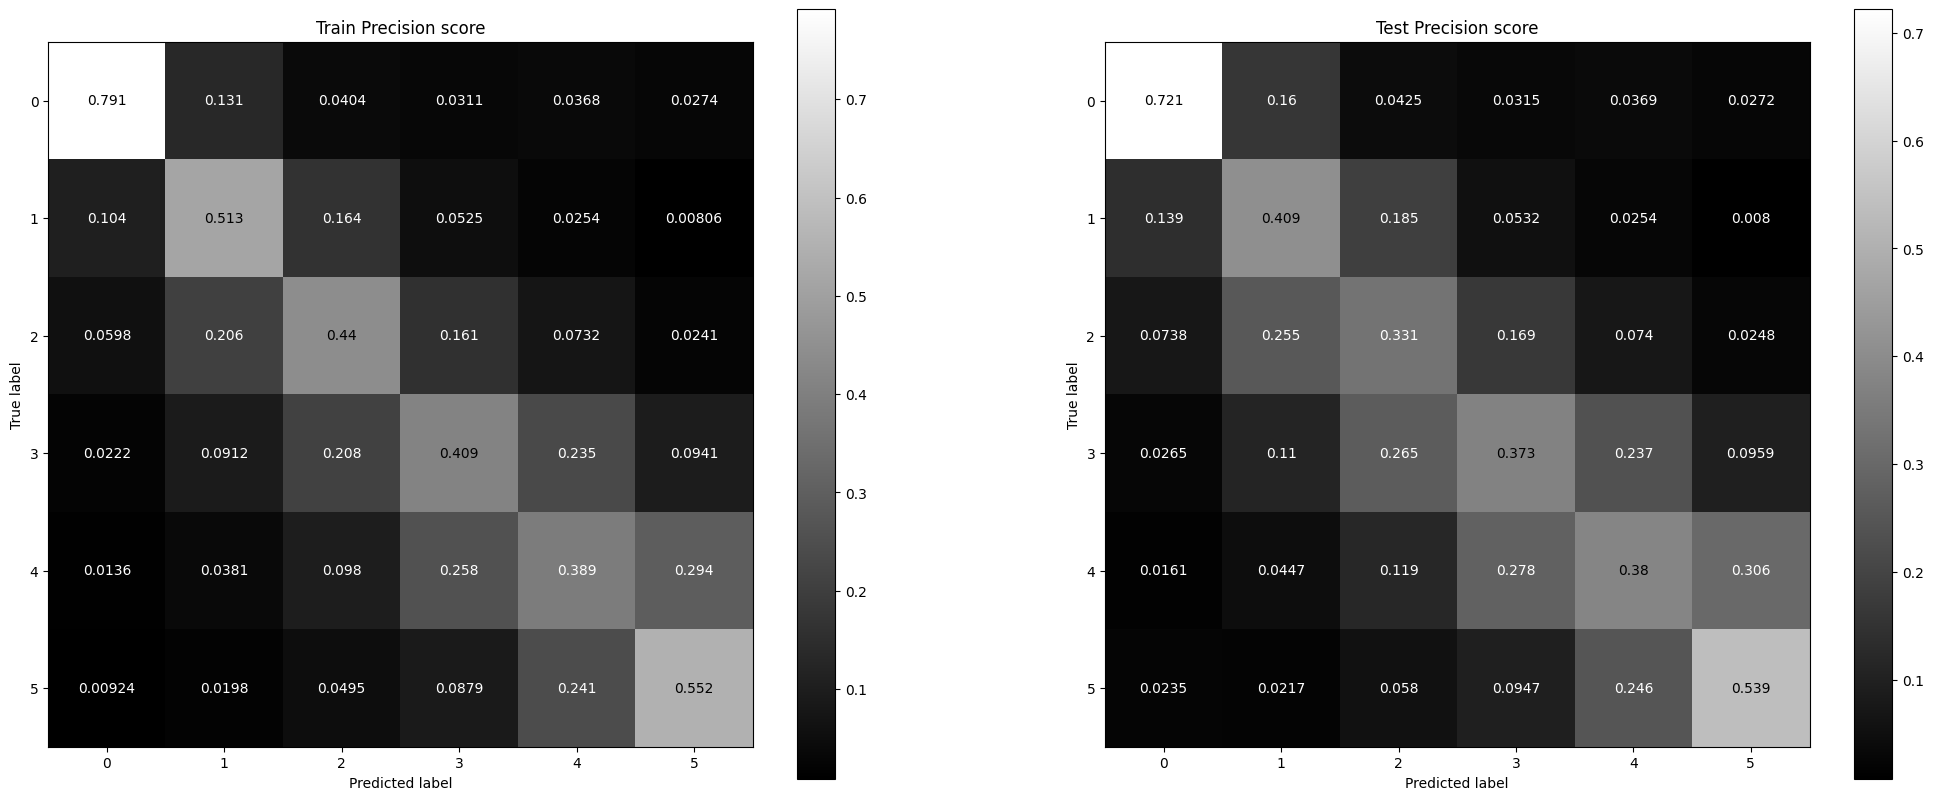

In [21]:
figure, axes = plt.subplots(1, 2, figsize=(25,10))
plot_confusion_matrix(clf_best, X_train, y_train, values_format='.3g', ax=axes[0], normalize='pred', cmap='gist_gray')  
plot_confusion_matrix(clf_best, X_test, y_test, values_format='.3g', ax=axes[1], normalize='pred', cmap='gist_gray') 
axes[0].set_title('Train Precision score')
axes[1].set_title('Test Precision score') 
plt.show()

GridSearch on RandomForest to find best suited parameters for model

In [22]:
clf = RandomForestClassifier()
parameters = {'max_depth':[15],'min_samples_split':[20, 25]}
clf1 = GridSearchCV(clf, parameters, cv= 2, scoring='f1_macro', verbose=2, return_train_score=True, n_jobs=-1)
clf1.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15], 'min_samples_split': [20, 25]},
             return_train_score=True, scoring='f1_macro', verbose=2)

Evaluating scores and best parameters for model

In [23]:
bestScore = clf1.best_score_
best_params = clf1.best_params_
print('Best parameters are: ', best_params)

Best parameters are:  {'max_depth': 15, 'min_samples_split': 20}


Training model with best obtained Parameters

In [24]:
clf_best_rf = RandomForestClassifier(max_depth=15, min_samples_split=25)
clf_best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=25)

Finding Score of trained model

In [25]:
original = y_train   # max_depth=15, min_samples_split=20
predicted = clf_best_rf.predict(X_train.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.2879936318735618

In [26]:
original = y_test   # max_depth=15, min_samples_split=20
predicted = clf_best_rf.predict(X_test.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.2806890586134227

Confusion Matrix for Precision Score

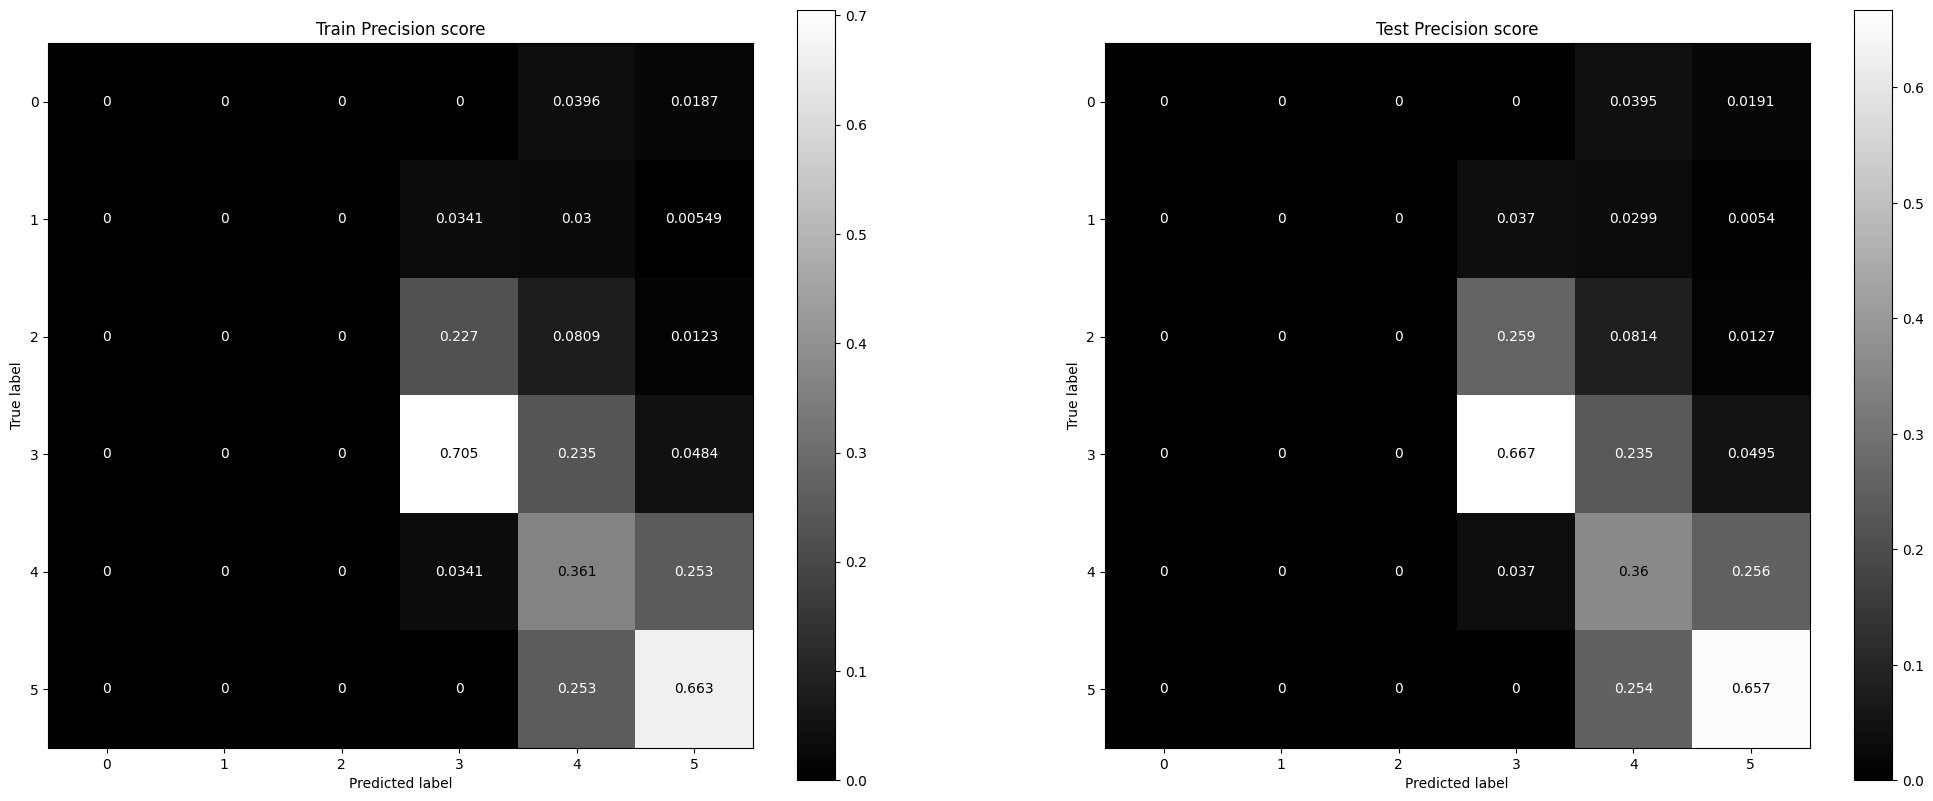

In [27]:
figure, axes = plt.subplots(1, 2, figsize=(25,10))
plot_confusion_matrix(clf_best_rf, X_train, y_train, values_format='.3g', ax=axes[0], normalize='pred', cmap='gist_gray')  
plot_confusion_matrix(clf_best_rf, X_test, y_test, values_format='.3g', ax=axes[1], normalize='pred', cmap='gist_gray') 
axes[0].set_title('Train Precision score')
axes[1].set_title('Test Precision score') 
plt.show()

Observation:

Of all the different algorithms we used for training purpose, Logistic Regression classifier gives best performance
We will use Logistic Regression trained model for predicting the ratings

In [37]:
books_users_path_processed_csv = 'content/df_books_users_processed.csv.gz'
df_books_users_processed = pd.read_csv(books_users_path_processed_csv)

In [40]:
books_path_processed_csv = "content/df_books_processed.csv.gz"
df_books_processed = pd.read_csv(books_path_processed_csv)

In [42]:
final_review_path = 'content/df_final_review.csv.gz'
df_final_review = pd.read_csv(final_review_path)

In [44]:
import pickle

# Load le1 from the pickle file
with open('content/le1.pkl', 'rb') as p:
    le1 = pickle.load(p)

# Load le4 from the pickle file
with open('content/le4.pkl', 'rb') as p:
    le4 = pickle.load(p)

# Load le7 from the pickle file
with open('content/le7.pkl', 'rb') as p:
    le7 = pickle.load(p)

# Load le9 from the pickle file
with open('content/le9.pkl', 'rb') as p:
    le9 = pickle.load(p)

In [63]:
books_path_processed_csv = "content/df_books_processed.csv.gz"
df_books_processed = pd.read_csv(books_path_processed_csv)

In [105]:
with open("content/vectorizer_title.pkl", "rb") as p:
    vectorizer_title = load(p)   
with open('content/vectorizer_review.pkl', 'rb') as p:
    vectorizer_review = load(p)

In [109]:
with open("content/norm.pkl", "rb") as p:
    norm = load(p)  

In [110]:
def content_recommendation():
  user_id = str(input('Enter user_id: '))
  book_id = set(df_books_users_processed[df_books_users_processed['user_id'] == user_id]['book_id'])
  user_books = df_books_processed[(~df_books_processed['book_id'].isin(list(book_id)))].merge(df_final_review, on='book_id')
  user_books['user_id'] = len(user_books)*[user_id]
  user_books.reset_index(drop=True, inplace=True)
  user_books = user_books[user_books['book_id'].isin(le1.classes_)]
  user_books['book_id_mapped'] = le1.transform(user_books['book_id'])
  user_books['publisher_mapped'] = le4.transform(user_books['publisher'])
  user_books['is_ebook_mapped'] = le7.transform(user_books['is_ebook'])
  user_books['user_id_mapped'] = le9.transform(user_books['user_id'])
  user_books['combined_processed_review'].fillna("", inplace=True)
  tfidf_title = vectorizer_title.transform(user_books['mod_title'])
  tfidf_review = vectorizer_review.transform(user_books['combined_processed_review'])
  user_book_numeric = user_books[['book_id_mapped', 'publisher_mapped', 'is_ebook_mapped', 'user_id_mapped', 'publication_year', 'ratings_count', 'average_rating', 'num_pages']]
  data_scaled = norm.transform(user_book_numeric)
  data_scaled = hstack((data_scaled, tfidf_title, tfidf_review), dtype = np.float32)

  prediction = clf_lr.predict(data_scaled.tocsr())
  user_books['rating'] = prediction
  top_50_books_for_user_content = user_books.sort_values(by=['rating'], ascending=False)[:50]
  book_title_liked_by_user = set(df_books_users_processed[df_books_users_processed['book_id'].isin(book_id)].sort_values(by='rating', ascending=False)['title_without_series'])
  print('Books highly rated by given user: \n')
  for count, books in enumerate(list(book_title_liked_by_user)[:20]):
    print(count+1,'.  ',books)
  return top_50_books_for_user_content[['book_id', 'title_without_series', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})

content_recommendation()

Enter user_id:  fcddf0227aafbf744a7714ac4409d373


Books highly rated by given user: 

1 .   The Queen of Zombie Hearts (White Rabbit Chronicles, #3)
2 .   The Dust Bowl Through the Lens: How Photography Revealed and Helped Remedy a National Disaster
3 .   Blue Is the Warmest Color
4 .   People Who Said No: Courage Against Oppression
5 .   Blue Pills:  A Positive Love Story
6 .   Sweet Deception (Veiled Seduction, #2)
7 .   Charles Dickens and the Street Children of London
8 .   Love and Other Scandals (Scandalous, #1)
9 .   The Legend of Wonder Woman Vol. 1: Origins
10 .   The Unbeatable Squirrel Girl, Volume 2: Squirrel You Know It's True
11 .   Rat Queens, Vol. 1: Sass & Sorcery
12 .   Introducing Feminism: A Graphic Guide
13 .   Howard the Duck #1
14 .   Rapunzel
15 .   The Woman Who Flummoxed the Fairies
16 .   I Work at a Public Library: A Collection of Crazy Stories from the Stacks
17 .   Where Are My Books?
18 .   Poisoned Apples: Poems for You, My Pretty
19 .   Howard the Duck #4
20 .   Bob's Burgers: Medium Rare


,book_id,title_without_series,average_rating,image_url,url
662165,22017381,"101 Nights: Volume One (101 Nights, #1-3)",4.370000,,Goodreads
159658,10423078,"I Zombie I (I Zombie, #1)",3.740000,,Goodreads
159645,2564603,Asylum Denied: A Refugee's Struggle for Safety in America,3.970000,,Goodreads
291479,17342262,"The Sleeping Partner (Sarah Tolerance, #3)",4.080000,,Goodreads
159647,190652,No Pasaran! Vol. 2,4.060000,,Goodreads


# Collaborative Filtering

User-User Similarity

In [ ]:
def similar_users():
  # get the user id 
  user_id = str(input('Enter user_id: '))
  # ia cartile apreciate the utilizator
  books_liked_by_user = set(df_books_users_processed[df_books_users_processed['user_id']== user_id]['book_id'])
  # ia numarul cartilor comune apreciate pentru fiecare utilizator
  count_other_similar_users = df_books_users_processed[df_books_users_processed['book_id'].isin(books_liked_by_user)]['user_id'].value_counts()
  df_similar_user = count_other_similar_users.to_frame().reset_index()
  df_similar_user.columns = ['user_id', 'matching_book_count'] # doar coloanele astea ne intereseaza
  # se selecteaza doar 1% din ei (adica cei mai asemanatori)
  top_onepercent_similar_users = df_similar_user[df_similar_user['matching_book_count']>=np.percentile(df_similar_user['matching_book_count'], 99)]
  top_users = set(top_onepercent_similar_users['user_id'])
  # construieste matricea une randul = utilizator, coloana = carte, celula = raitng-ul
  df_similar_user = df_books_users_processed[(df_books_users_processed['user_id'].isin(top_users))][['user_id_mapped', 'book_id_mapped', 'user_rating', 'user_id', 'book_id', 'title_without_series', 'ratings_count', 'cover_page', 'book_url', 'book_average_rating']]
  ratings_mat_coo = coo_matrix((df_similar_user["user_rating"], (df_similar_user["user_id_mapped"], df_similar_user["book_id_mapped"])))
  ratings_mat = ratings_mat_coo.tocsr()
  # calculeaza similaritatea dintre utilizatorul introdus si toti ceilalti
  my_index = list(le9.transform([user_id]))[0]
  similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()
  # ia primii 50 cei mai asemanatori
  similar_users_index = np.argsort(similarity)[-1:-51:-1]
  # filtreaza recomandarilor astfel incat sa excluda cartile deja apreciate de utilizator
  df_similar_users_refined = df_similar_user[(df_similar_user["user_id_mapped"].isin(similar_users_index)) & (~df_similar_user['book_id'].isin(books_liked_by_user))].copy()
  
  # printeaza primele 20carti apreciate de user-ul curent (todo: muta de aici asta cand scrii in ide)
  book_title_liked_by_user = set(df_books_users_processed[df_books_users_processed['book_id'].isin(books_liked_by_user)].sort_values(by='user_rating', ascending=False)['title_without_series'])
  print('Books highly rated by given user: \n')
  for count, books in enumerate(list(book_title_liked_by_user)[:20]):
    print(count+1,'.  ',books)
  return df_similar_users_refined

def recommendation(df_similar_users_refined):  
  # numără recomandările pentru fiecare carte în funcție de evaluările utilizatorilor similari.
  all_recs = df_similar_users_refined['book_id'].value_counts()
  all_recs = all_recs.to_frame().reset_index()
  all_recs.columns = ["book_id", "book_count"]
  all_recs_book_id = list(all_recs['book_id'])

  # Se calculează un scor pentru fiecare carte, ținând cont de numărul de recomandări și popularitatea cărții 
  all_recs_new = df_books_processed[df_books_processed['book_id'].isin(all_recs_book_id)]
  all_recs_new = all_recs_new.merge(all_recs, on='book_id', how='inner')
  all_recs_new['score'] = all_recs_new['book_count'] * (all_recs_new['book_count']/all_recs_new['ratings_count'])
  return all_recs_new.sort_values(by='score', ascending=False)[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

df_similar_users_refined = similar_users()  
recommendation(df_similar_users_refined)

Item-Item Similarity

In [ ]:
def similar_item_recommendation():
  # id-ul cartii
  book_id = (input('Enter book_id: '))
  # utilizatorii care au apreciat cartea
  users_who_liked_book = set(df_books_users_processed[df_books_users_processed['book_id']== book_id]['user_id'])   
  # evaluările altor cărți ale utilizatorilor care au apreciat cartea data
  books_id_remaining = df_books_users_processed[(df_books_users_processed['user_id'].isin(list(users_who_liked_book)))]
  # matrice de evaluări unde rândurile reprezintă cărțile și coloanele reprezintă utilizatorii.
  ratings_mat_coo = coo_matrix((books_id_remaining["user_rating"], (books_id_remaining["book_id_mapped"], books_id_remaining["user_id_mapped"])))
  ratings_mat = ratings_mat_coo.tocsr()
  my_index = list(le1.transform([book_id]))[0]
  # similaritatea cosinus între cartea dată și toate celelalte cărți
  similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()
  # Se identifică indexurile celor mai similare 50 de cărți
  similar_books_index = np.argsort(similarity)[-1:-51:-1]
  # scor de similaritate
  score = [(score, book) for score, book in enumerate(similar_books_index)]
  df_score = pd.DataFrame(score, columns =['score', 'book_id_mapped'])
  # Se combină datele din df_books_users_processed cu df_score pentru a obține ID-urile cărților și scorurile lor.
  df_similar_books_to_recommend = (df_books_users_processed[(df_books_users_processed['book_id_mapped'].isin(list(similar_books_index)))].merge(df_score, on='book_id_mapped'))[['book_id', 'score']]
  # se elimina duplicatele
  unique_df_similar_books_to_recommend = df_similar_books_to_recommend.drop_duplicates(keep='first')
  # Se combină df_books_processed cu unique_df_similar_books_to_recommend pentru a obține toate detaliile cărților recomandate.
  final_books = (df_books_processed[df_books_processed['book_id'].isin(set(unique_df_similar_books_to_recommend['book_id'].values))].merge(unique_df_similar_books_to_recommend, on='book_id')).sort_values(by='score')
  print('Title of book given by customer:', str(df_books_processed[df_books_processed['book_id']==book_id]['title_without_series'].values[0]).strip())
  return final_books[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

similar_item_recommendation() 

SVD(Singular-Valued Decomposition)

In [121]:
df_svd = df_books_users_processed[['user_id', 'book_id', 'rating']]
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_svd, reader)
trainset, testset = model_selection.train_test_split(data, test_size=0.30)
model = SVD()
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.0708


1.0708030996858067

In [122]:
with open('content/model_svd.pkl', 'wb') as p:
    dump(model, p)

In [131]:
def recommendation_svd():
  user_id = str(input('Enter user_id: '))
  book_id = set(df_books_users_processed[df_books_users_processed['user_id']==user_id]['book_id'])
  user_books = df_books_processed[~df_books_processed['book_id'].isin(book_id)]
  user_books['user_id'] = len(user_books)*[user_id]
  user_books.reset_index(drop=True, inplace=True)
  user_books['user_rating'] = 0
  df_svd_predict = Dataset.load_from_df(user_books[['user_id', 'book_id', 'user_rating']], reader)
  NA, test = model_selection.train_test_split(df_svd_predict, test_size=1.0)
  predictions = model.test(test)
  predictions = [prediction.est for prediction in predictions]
  user_books['rating'] = predictions
  top_50_books_for_user_content = user_books.sort_values(by=['rating'], ascending=False)[:50]
  top_50_books_for_user_content.to_csv('top_50_books_for_user_content.csv', index=False)
  book_title_liked_by_user = set(df_books_users_processed[df_books_users_processed['user_id']==user_id].sort_values(by='rating', ascending=False)['title_without_series'])
  print('Books highly rated by given user: \n')
  for count, books in enumerate(list(book_title_liked_by_user)[:20]):
    print(count+1,'.  ',books)
  return top_50_books_for_user_content[['book_id', 'title_without_series', 'rating', 'average_rating', 'image_url', 'url']].head(5).style.format({'image_url': show_image, 'url': make_clickable})


recommendation_svd()
     

Enter user_id:  fcddf0227aafbf744a7714ac4409d373


Books highly rated by given user: 

1 .   The Queen of Zombie Hearts (White Rabbit Chronicles, #3)
2 .   The Dust Bowl Through the Lens: How Photography Revealed and Helped Remedy a National Disaster
3 .   Blue Is the Warmest Color
4 .   People Who Said No: Courage Against Oppression
5 .   Blue Pills:  A Positive Love Story
6 .   Sweet Deception (Veiled Seduction, #2)
7 .   Charles Dickens and the Street Children of London
8 .   The Legend of Wonder Woman Vol. 1: Origins
9 .   Love and Other Scandals (Scandalous, #1)
10 .   The Unbeatable Squirrel Girl, Volume 2: Squirrel You Know It's True
11 .   Rat Queens, Vol. 1: Sass & Sorcery
12 .   Introducing Feminism: A Graphic Guide
13 .   Howard the Duck #1
14 .   Rapunzel
15 .   The Woman Who Flummoxed the Fairies
16 .   I Work at a Public Library: A Collection of Crazy Stories from the Stacks
17 .   Where Are My Books?
18 .   Poisoned Apples: Poems for You, My Pretty
19 .   Howard the Duck #4
20 .   Bob's Burgers: Medium Rare


,book_id,title_without_series,rating,average_rating,image_url,url
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)",3.753051,4.030000,,Goodreads
452174,989400,Bailey's Cafe,3.753051,4.040000,,Goodreads
452176,36252486,The Alpha Prince (Kingdom of Askara #3),3.753051,4.270000,,Goodreads
452177,24398995,"Reckless (The Burton & Kazmaroff Mysteries, #1)",3.753051,3.580000,,Goodreads
452178,98476,"Stonewall in the Valley: Thomas J. ""Stonewall"" Jackson's Shenandoah Valley Campaign, Spring 1862",3.753051,4.230000,,Goodreads
